In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pymssql as mssql
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


In [2]:
# 그래프 그리기 위한 matplolib
%matplotlib inline
plt.style.use('ggplot')
#폰트깨짐방지
mpl.rcParams['axes.unicode_minus']=False

## 아웃라이어 제거한 데이터로 데이터 탐색 시작

In [3]:
from IPython.display import Image

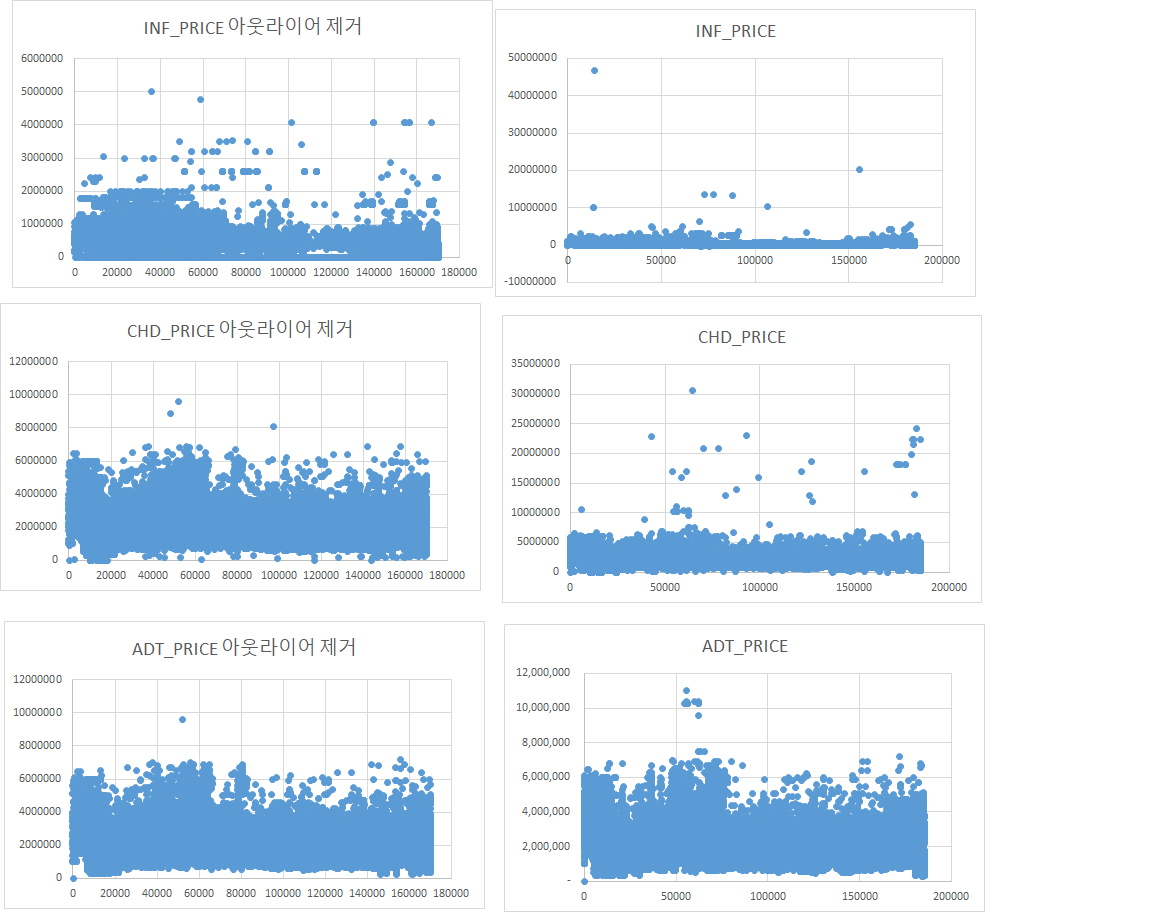

In [4]:
Image("TRAIN_OUTLIER.PNG")

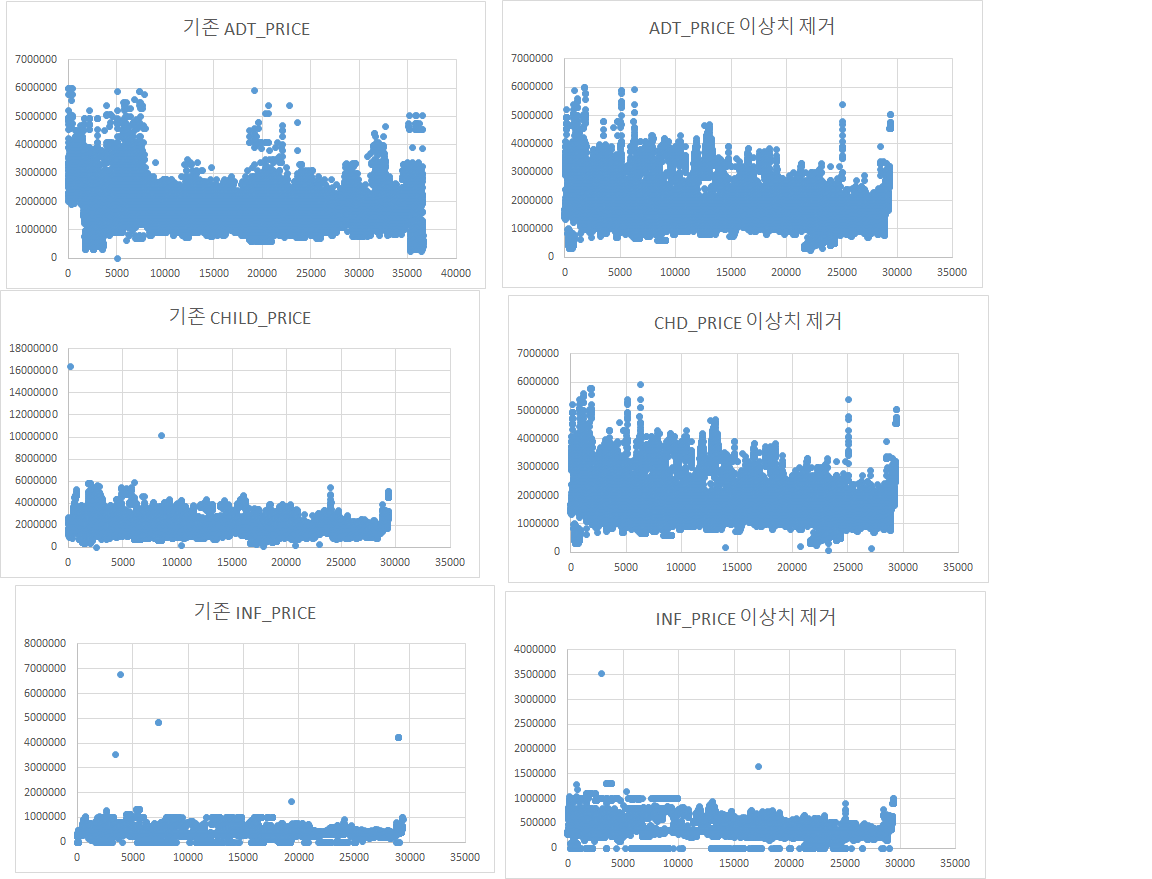

In [5]:
Image("TEST_OULIER.PNG")

- p1,p2,p3 가격 피쳐들의 아웃라이어들을 sql에서 제거하여 재추출
- 가격대 분포에서 이상치에 해당되는 것들을 눈으로 직접 확인 결과 가격대가 원래부터 높은 상품도 있음
- 이상치로 판단하고 제거한 데이터로는 상품가격이 직원들의 실수로 0이 하나더 붙은 상품이나 inf_price가 adt_price보다 높은 상품들 제거
- 이 상품들에 대한 평균값이 흐려지지 않기 위해 평균값 계산에서만 제거하는 것을 고려했지만 가격 평균과 가격 총합에서 제거가 되었는데 해당값들의 다른 정보들은 정상적으로 들어가 있지만 출발자수에 변동도 생길수 있기 때문에 결과값 예측에 방해될 요소가 있음으로 확실하게 오류데이터로 전체 정의내리고 삭제진행
- 대부분 제대로 들어가지 않은 상품들이거나 예약이 없는 상품들이므로 출발자수 약 40명정도의 차이로 데이터에 큰 영향이 없을것으로 최종 판단

In [6]:
train_outclear = pd.read_csv("train_outclear.csv", parse_dates=["datetime"])

In [7]:
train_outclear.head()

datetime  tourday  b1  b2   b3  f1   f2  f3  f4  x1  ...  ar24  ar25  \
0 2015-01-01        9   2  12  101   3  456  30   0   0  ...     0     0   
1 2015-01-02        9   3   2   81   3  304  27  -1   0  ...     2     0   
2 2015-01-03        8   1   4   81   3  285  14  -1   0  ...     0     0   
3 2015-01-04        9   2   3   82   4  349  23   0   0  ...     0     0   
4 2015-01-05       10   4   5   54   3  202  20   0   1  ...     0     0   

   ar26  ar27  ar28  ar29  art1  art2  art3  count  
0     0     0     0     0    53     0    62    321  
1     0     0     0     0    44     0    42    271  
2     0     0     0     0    39     0    47    315  
3     0     0     1     0    37     0    50    271  
4     0     0     0     0    39     0    24    109  

[5 rows x 59 columns]

In [8]:
test_outclear = pd.read_csv("test_outclear.csv", parse_dates=["datetime"])

In [9]:
test_outclear.head()

datetime  tourday  b1  b2  b3  f1   f2  f3  f4  x1  ...  ar23  ar24  ar25  \
0 2019-01-01        9   7   1  84   4  418  13   0   0  ...     0     0     0   
1 2019-01-02        9   9   2  94   4  450  34   0   0  ...     0     0     0   
2 2019-01-03        9   9   2  83   3  316  13   0   0  ...     0     0     0   
3 2019-01-04        9   1   2  72   3  262  28   0   0  ...     0     1     0   
4 2019-01-05        9   6   0  68   3  222  15   0   0  ...     0     0     0   

   ar26  ar27  ar28  ar29  art1  art2  art3  
0     0     0     0     0    48     1    43  
1     0     0     0     0    52     1    52  
2     0     0     0     0    52     1    41  
3     0     0     0     0    33     1    41  
4     0     0     0     0    35     1    38  

[5 rows x 58 columns]

In [10]:
train_outclear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  1461 non-null   datetime64[ns]
 1   tourday   1461 non-null   int64         
 2   b1        1461 non-null   int64         
 3   b2        1461 non-null   int64         
 4   b3        1461 non-null   int64         
 5   f1        1461 non-null   int64         
 6   f2        1461 non-null   int64         
 7   f3        1461 non-null   int64         
 8   f4        1461 non-null   int64         
 9   x1        1461 non-null   int64         
 10  x2        1461 non-null   int64         
 11  n1        1461 non-null   int64         
 12  n2        1461 non-null   int64         
 13  p1        1461 non-null   int64         
 14  p2        1461 non-null   int64         
 15  p3        1461 non-null   int64         
 16  p4        1461 non-null   int64         
 17  p5        1461

In [11]:
test_outclear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 58 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  365 non-null    datetime64[ns]
 1   tourday   365 non-null    int64         
 2   b1        365 non-null    int64         
 3   b2        365 non-null    int64         
 4   b3        365 non-null    int64         
 5   f1        365 non-null    int64         
 6   f2        365 non-null    int64         
 7   f3        365 non-null    int64         
 8   f4        365 non-null    int64         
 9   x1        365 non-null    int64         
 10  x2        365 non-null    int64         
 11  n1        365 non-null    int64         
 12  n2        365 non-null    int64         
 13  p1        365 non-null    int64         
 14  p2        365 non-null    int64         
 15  p3        365 non-null    int64         
 16  p4        365 non-null    int64         
 17  p5        365 no

In [12]:
##결측치가 있는지 없는지 체크
train_outclear.columns[train_outclear.isna().any()].tolist()

[]

In [13]:
##결측치가 있는지 없는지 체크
test_outclear.columns[test_outclear.isna().any()].tolist()

[]

In [14]:
## 데이터들의 분포 형태 확인
train_outclear.describe()

tourday           b1           b2           b3           f1  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean      9.095825     6.488022     2.222450   107.645448     3.164956   
std       0.359399     3.361653     2.457126    24.413004     0.914587   
min       8.000000     0.000000     0.000000    38.000000     1.000000   
25%       9.000000     3.000000     0.000000    90.000000     3.000000   
50%       9.000000     7.000000     1.000000   109.000000     3.000000   
75%       9.000000     9.000000     3.000000   126.000000     4.000000   
max      10.000000    19.000000    15.000000   165.000000     6.000000   

                f2           f3           f4           x1           x2  ...  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  ...   
mean    429.110883    22.455852    -2.768652     0.106092    45.266940  ...   
std     145.315816    11.862581     6.276931     0.321124    48.491052  ...   
min      94.000000     9.000000   -65.000000     0.000000    -5.000000  ...   
25%     321.000000    18.000000    -2.000000     0.000000     0.000000  ...   
50%     424.000000    21.000000    -1.000000     0.000000    32.000000  ...   
75%     526.000000    26.000000     0.000000     0.000000    66.000000  ...   
max     960.000000   412.000000     0.000000     2.000000   257.000000  ...   

              ar24    ar25         ar26         ar27         ar28  \
count  1461.000000  1461.0  1461.000000  1461.000000  1461.000000   
mean      0.441478     0.0     0.000684     0.232717     0.139630   
std       0.989066     0.0     0.026162     0.628586     0.346722   
min       0.000000     0.0     0.000000     0.000000     0.000000   
25%       0.000000     0.0     0.000000     0.000000     0.000000   
50%       0.000000     0.0     0.000000     0.000000     0.000000   
75%       0.000000     0.0     0.000000     0.000000     0.000000   
max       6.000000     0.0     1.000000     4.000000     1.000000   

              ar29         art1         art2         art3        count  
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  
mean      0.077344    62.299110     0.394935    53.661875   262.425736  
std       0.272306    18.144932     0.830548    11.538232   114.532520  
min       0.000000    17.000000     0.000000    17.000000    12.000000  
25%       0.000000    47.000000     0.000000    46.000000   180.000000  
50%       0.000000    62.000000     0.000000    54.000000   251.000000  
75%       0.000000    76.000000     0.000000    62.000000   336.000000  
max       2.000000   113.000000     4.000000    89.000000  1036.000000  

[8 rows x 58 columns]

In [15]:
test_outclear.describe()

tourday          b1          b2          b3          f1          f2  \
count  365.000000  365.000000  365.000000  365.000000  365.000000  365.000000   
mean     9.104110    8.084932    2.060274   70.328767    3.035616  293.712329   
std      0.406147    3.476122    1.982529   19.987809    1.035811  125.747969   
min      8.000000    1.000000    0.000000   19.000000    0.000000  -10.000000   
25%      9.000000    5.000000    1.000000   57.000000    2.000000  209.000000   
50%      9.000000    8.000000    2.000000   71.000000    3.000000  290.000000   
75%      9.000000   10.000000    3.000000   84.000000    4.000000  379.000000   
max     10.000000   17.000000   11.000000  115.000000    5.000000  699.000000   

               f3          f4          x1          x2  ...        ar23  \
count  365.000000  365.000000  365.000000  365.000000  ...  365.000000   
mean    21.972603   -3.443836    0.389041   65.715068  ...    0.134247   
std      6.311016    6.142112    0.603916   44.821145  ...    0.349340   
min      0.000000  -41.000000    0.000000   -4.000000  ...    0.000000   
25%     18.000000   -3.000000    0.000000   33.000000  ...    0.000000   
50%     22.000000   -1.000000    0.000000   65.000000  ...    0.000000   
75%     26.000000    0.000000    1.000000   91.000000  ...    0.000000   
max     43.000000    0.000000    3.000000  231.000000  ...    2.000000   

             ar24   ar25   ar26   ar27   ar28   ar29        art1        art2  \
count  365.000000  365.0  365.0  365.0  365.0  365.0  365.000000  365.000000   
mean     0.287671    0.0    0.0    0.0    0.0    0.0   39.008219    1.068493   
std      0.453298    0.0    0.0    0.0    0.0    0.0   11.422334    0.769058   
min      0.000000    0.0    0.0    0.0    0.0    0.0   11.000000    0.000000   
25%      0.000000    0.0    0.0    0.0    0.0    0.0   31.000000    0.000000   
50%      0.000000    0.0    0.0    0.0    0.0    0.0   40.000000    1.000000   
75%      1.000000    0.0    0.0    0.0    0.0    0.0   47.000000    2.000000   
max      1.000000    0.0    0.0    0.0    0.0    0.0   71.000000    3.000000   

             art3  
count  365.000000  
mean    40.397260  
std     12.201535  
min     11.000000  
25%     33.000000  
50%     42.000000  
75%     49.000000  
max     72.000000  

[8 rows x 57 columns]

In [16]:
train_outclear.columns

Index(['datetime', 'tourday', 'b1', 'b2', 'b3', 'f1', 'f2', 'f3', 'f4', 'x1',
       'x2', 'n1', 'n2', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'up1', 'um1',
       'uc1', 's1', 's2', 'o1', 'o2', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6',
       'ar7', 'ar8', 'ar9', 'ar10', 'ar11', 'ar12', 'ar13', 'ar14', 'ar15',
       'ar16', 'ar17', 'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24',
       'ar25', 'ar26', 'ar27', 'ar28', 'ar29', 'art1', 'art2', 'art3',
       'count'],
      dtype='object')

In [17]:
test_outclear.columns

Index(['datetime', 'tourday', 'b1', 'b2', 'b3', 'f1', 'f2', 'f3', 'f4', 'x1',
       'x2', 'n1', 'n2', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'up1', 'um1',
       'uc1', 's1', 's2', 'o1', 'o2', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6',
       'ar7', 'ar8', 'ar9', 'ar10', 'ar11', 'ar12', 'ar13', 'ar14', 'ar15',
       'ar16', 'ar17', 'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24',
       'ar25', 'ar26', 'ar27', 'ar28', 'ar29', 'art1', 'art2', 'art3'],
      dtype='object')

count    1461.000000
mean      262.425736
std       114.532520
min        12.000000
25%       180.000000
50%       251.000000
75%       336.000000
max      1036.000000
Name: count, dtype: float64


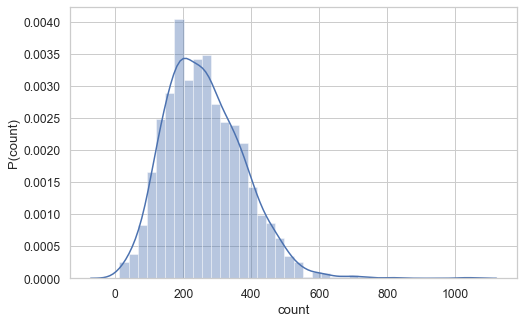

In [18]:
print(train_outclear['count'].describe())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train_outclear['count'], norm_hist=False, kde=True
).set(xlabel='count', ylabel='P(count)');

In [19]:
##피어슨 상관계수를 통한 상관관계 측정
train_outclear.corr(method = 'pearson')

tourday        b1        b2        b3        f1        f2        f3  \
tourday  1.000000  0.087689 -0.159887 -0.302369 -0.106467 -0.238353 -0.026479   
b1       0.087689  1.000000 -0.133471  0.523027 -0.089916  0.357687  0.139363   
b2      -0.159887 -0.133471  1.000000 -0.026956  0.055590  0.077079  0.034774   
b3      -0.302369  0.523027 -0.026956  1.000000  0.105632  0.739979  0.143332   
f1      -0.106467 -0.089916  0.055590  0.105632  1.000000  0.688675  0.182331   
f2      -0.238353  0.357687  0.077079  0.739979  0.688675  1.000000  0.243204   
f3      -0.026479  0.139363  0.034774  0.143332  0.182331  0.243204  1.000000   
f4      -0.037766 -0.017527 -0.024700  0.018978  0.144274  0.108012 -0.015841   
x1       0.012743 -0.140630  0.062952 -0.113670 -0.127259 -0.150803 -0.045428   
x2      -0.128255 -0.142105  0.092714  0.072067 -0.072700 -0.009248 -0.024268   
n1       0.068909  0.262301 -0.431921  0.313240 -0.092978  0.121129  0.008921   
n2      -0.272080  0.610595 -0.002126  0.991957  0.081330  0.729959  0.151645   
p1       0.034670  0.018492  0.171192  0.031159 -0.018016  0.022242  0.050263   
p2       0.036860  0.049520  0.147785  0.060952 -0.029254  0.034513  0.060076   
p3       0.038728  0.047817  0.018427  0.017189 -0.181955 -0.107957  0.004124   
p4      -0.207891  0.503105  0.130534  0.838236  0.058603  0.618164  0.150605   
p5      -0.204255  0.514607  0.115854  0.844375  0.052609  0.617885  0.154531   
p6      -0.242410  0.553967  0.037643  0.908145  0.011567  0.625216  0.133641   
up1     -0.283983  0.599961  0.051269  0.991117  0.091618  0.738713  0.153882   
um1     -0.252879  0.641955  0.072959  0.966060  0.082008  0.722998  0.168465   
uc1     -0.151763  0.313576  0.131134  0.479251  0.163422  0.456046  0.217446   
s1      -0.147850  0.667974  0.004645  0.794793  0.062453  0.607812  0.209407   
s2       0.048106 -0.018935 -0.016930  0.009382  0.003978  0.006885  0.006470   
o1      -0.104370  0.600867 -0.079918  0.626039  0.043396  0.480769  0.205355   
o2       0.086429  0.173908 -0.306570  0.093597 -0.006159  0.052038  0.064751   
ar1     -0.218044  0.409922  0.138874  0.748535  0.072952  0.559631  0.079947   
ar2     -0.236864  0.622657 -0.039654  0.809898  0.099403  0.625367  0.119249   
ar3      0.156102  0.189286  0.111255  0.233996 -0.059882  0.141146  0.069258   
ar4      0.006350 -0.067831 -0.163387  0.031658 -0.052298 -0.031881  0.071898   
ar5     -0.152027  0.096024 -0.090123  0.243621 -0.092753  0.091638  0.025370   
ar6     -0.221271 -0.235396  0.081107  0.232669  0.089624  0.186600 -0.057997   
ar7     -0.129744  0.401735 -0.021829  0.488870  0.127271  0.421905  0.086556   
ar8     -0.091715 -0.069071  0.236729 -0.128729  0.044058 -0.031017  0.005057   
ar9     -0.111334  0.016383  0.159062  0.151513  0.055999  0.141214  0.001699   
ar10     0.323997  0.467657 -0.110859  0.181944 -0.110960  0.088848  0.109235   
ar11    -0.032824 -0.164179  0.027762  0.148513  0.045897  0.102912  0.018201   
ar12    -0.093258  0.159630 -0.021602  0.282345 -0.169015  0.072500  0.054553   
ar13    -0.134701  0.208222  0.016693  0.216514 -0.080676  0.094043  0.048275   
ar14     0.060778  0.149887 -0.016935  0.071246 -0.043067  0.021058  0.064578   
ar15    -0.029612  0.057577  0.028191  0.110446 -0.038713  0.048124  0.022019   
ar16    -0.157951  0.132402 -0.012488  0.149807 -0.005422  0.095132  0.066505   
ar17    -0.038345  0.314235  0.070645  0.281635  0.148715  0.308217  0.047634   
ar18    -0.033816  0.083992  0.037185  0.056910 -0.050609 -0.002690  0.031783   
ar19    -0.017128  0.019338 -0.010173 -0.000383  0.011826  0.014907  0.012875   
ar20     0.021129 -0.100902  0.042254  0.033014  0.040393  0.043071 -0.045958   
ar21    -0.335022  0.155077  0.101081  0.539285  0.205509  0.504048  0.087208   
ar22    -0.082562  0.299927  0.036772  0.342694  0.016753  0.255618  0.165514   
ar23    -0.079323  0.239596  0.058200  0.269376 -0.007915  0.184991  0.140612   
ar24    -0.074775 -0.181028  0.135145 -0.

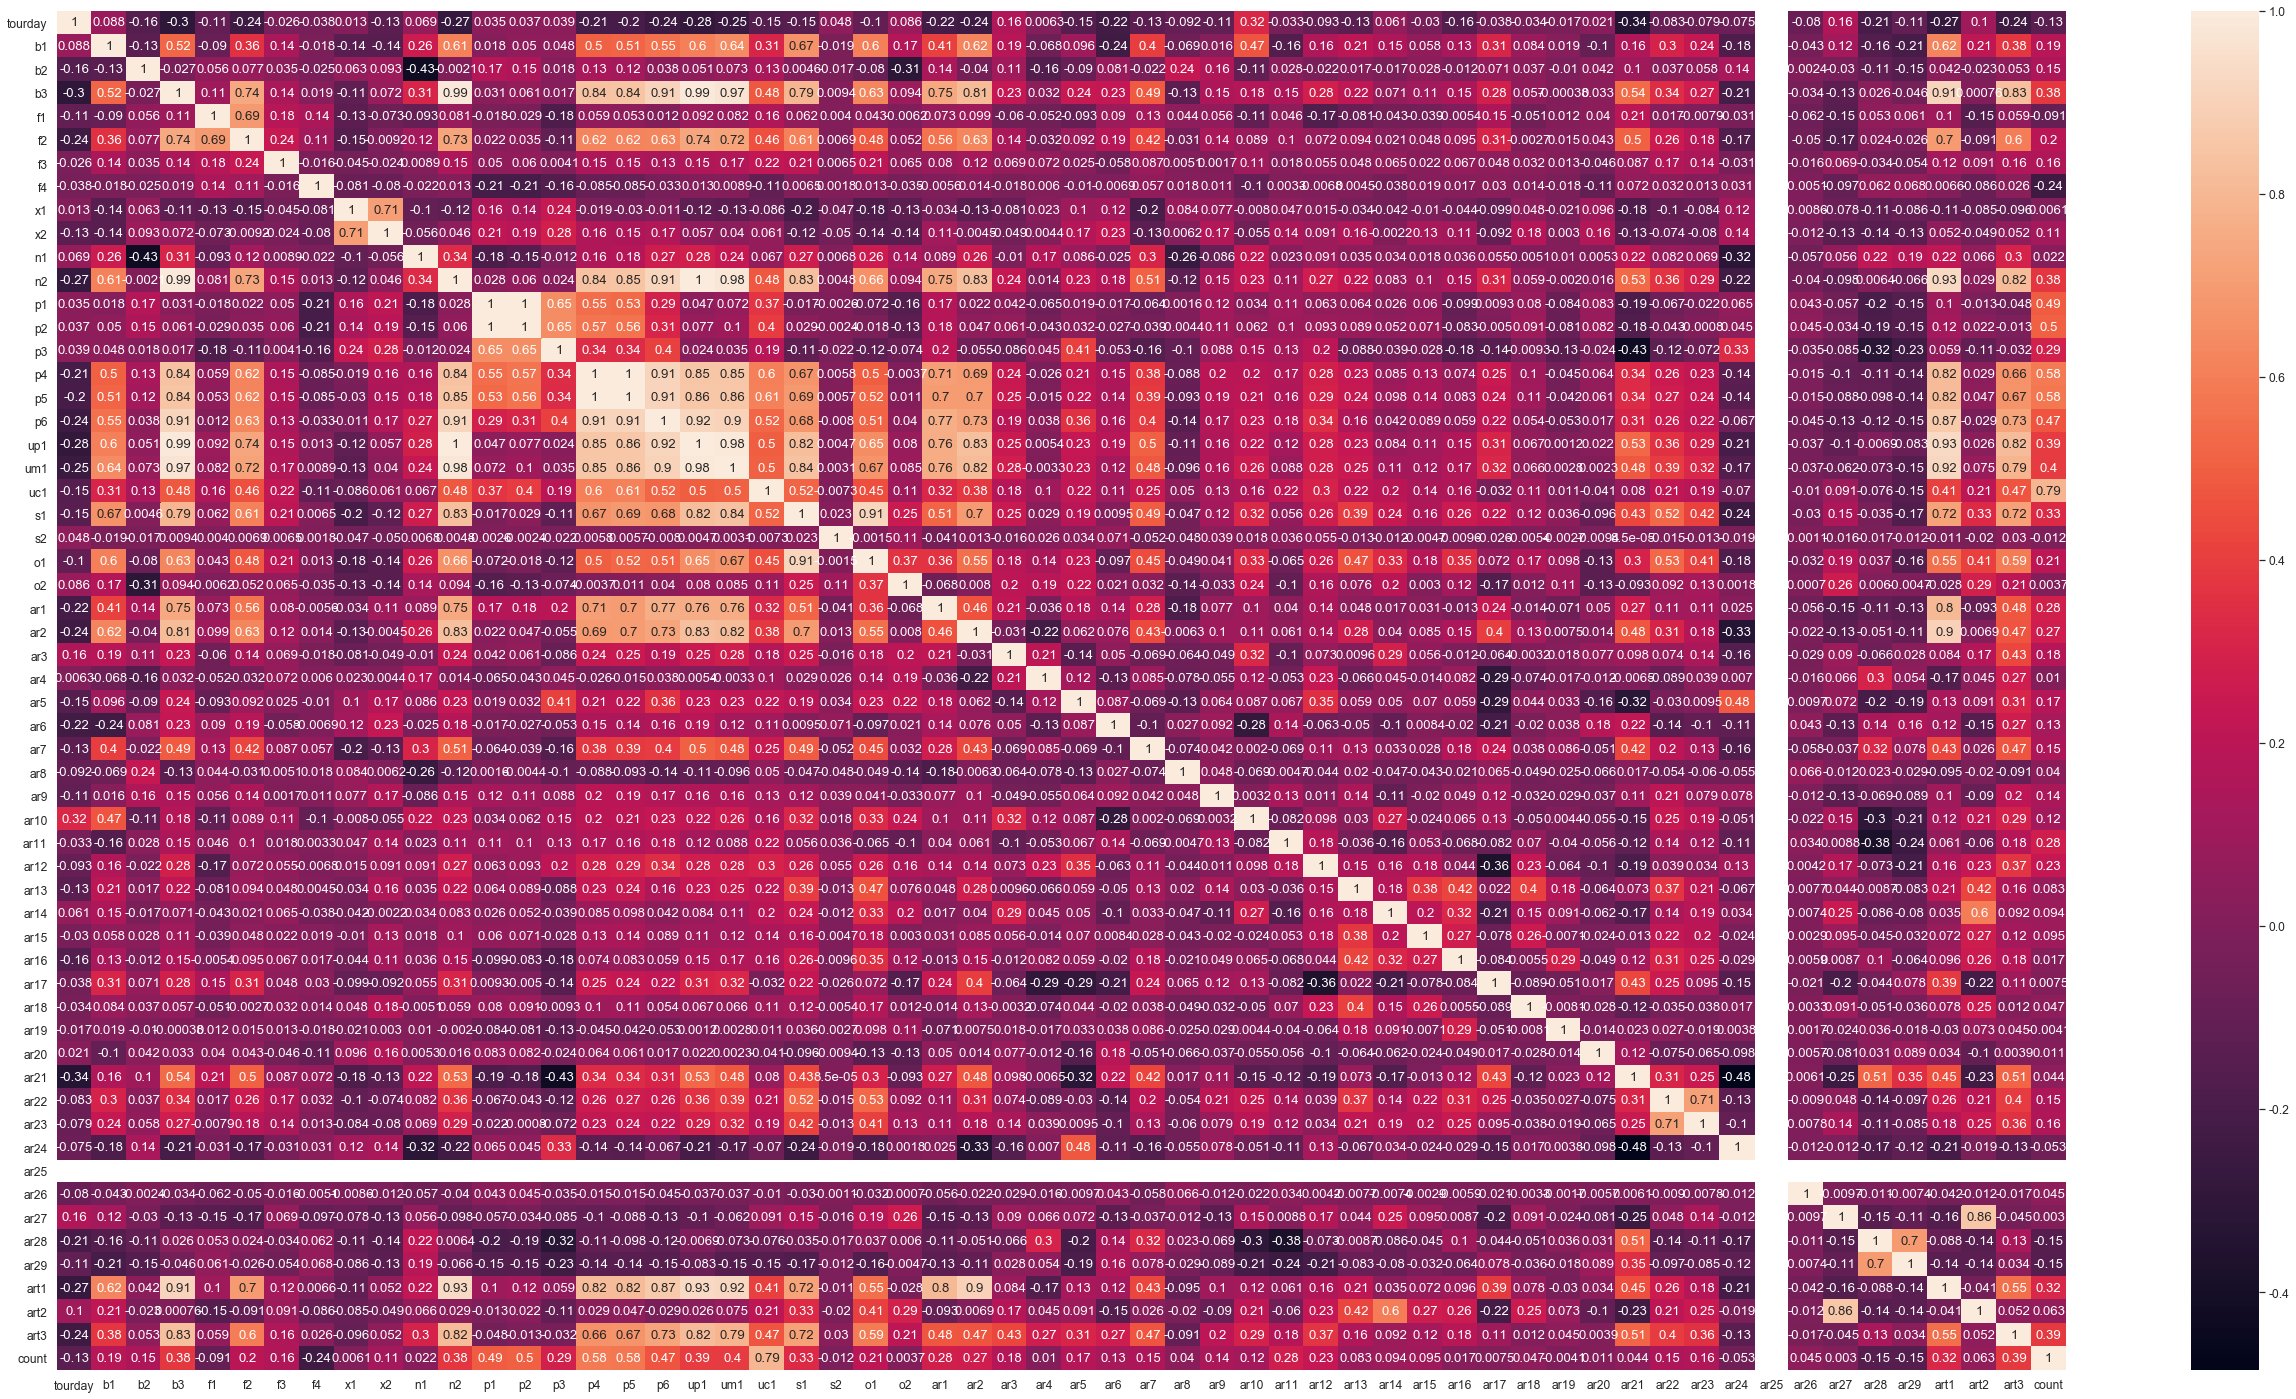

In [20]:
## 상관관계도를 시각화
transformed_corr_outclear = train_outclear.corr()
plt.figure(figsize=(45,25))
sns.heatmap(transformed_corr_outclear, annot=True)

In [23]:
features_outclear = train_outclear.select_dtypes([np.number]).columns.tolist()

In [26]:
train_outclear[features_outclear]

tourday  b1  b2   b3  f1   f2  f3  f4  x1  x2  ...  ar24  ar25  ar26  \
0           9   2  12  101   3  456  30   0   0   4  ...     0     0     0   
1           9   3   2   81   3  304  27  -1   0  65  ...     2     0     0   
2           8   1   4   81   3  285  14  -1   0  38  ...     0     0     0   
3           9   2   3   82   4  349  23   0   0  36  ...     0     0     0   
4          10   4   5   54   3  202  20   0   1  90  ...     0     0     0   
...       ...  ..  ..  ...  ..  ...  ..  ..  ..  ..  ...   ...   ...   ...   
1456        9   7   1  117   4  602  27   0   0  20  ...     0     0     0   
1457        9   3   2   99   3  396  22   0   0  36  ...     0     0     0   
1458        9   8   5  113   4  541  33  -1   0  19  ...     0     0     0   
1459        9   8   2  102   3  443  26  -2   0  30  ...     0     0     0   
1460       10  10   1   76   4  408  22   0   0   0  ...     0     0     0   

      ar27  ar28  ar29  art1  art2  art3  count  
0        0     0     0    53     0    62    321  
1        0     0     0    44     0    42    271  
2        0     0     0    39     0    47    315  
3        0     1     0    37     0    50    271  
4        0     0     0    39     0    24    109  
...    ...   ...   ...   ...   ...   ...    ...  
1456     0     0     0    76     1    48    241  
1457     0     0     0    42     1    61    273  
1458     0     0     0    73     1    52    381  
1459     0     1     0    54     1    57    250  
1460     0     0     0    38     0    49    114  

[1461 rows x 58 columns]

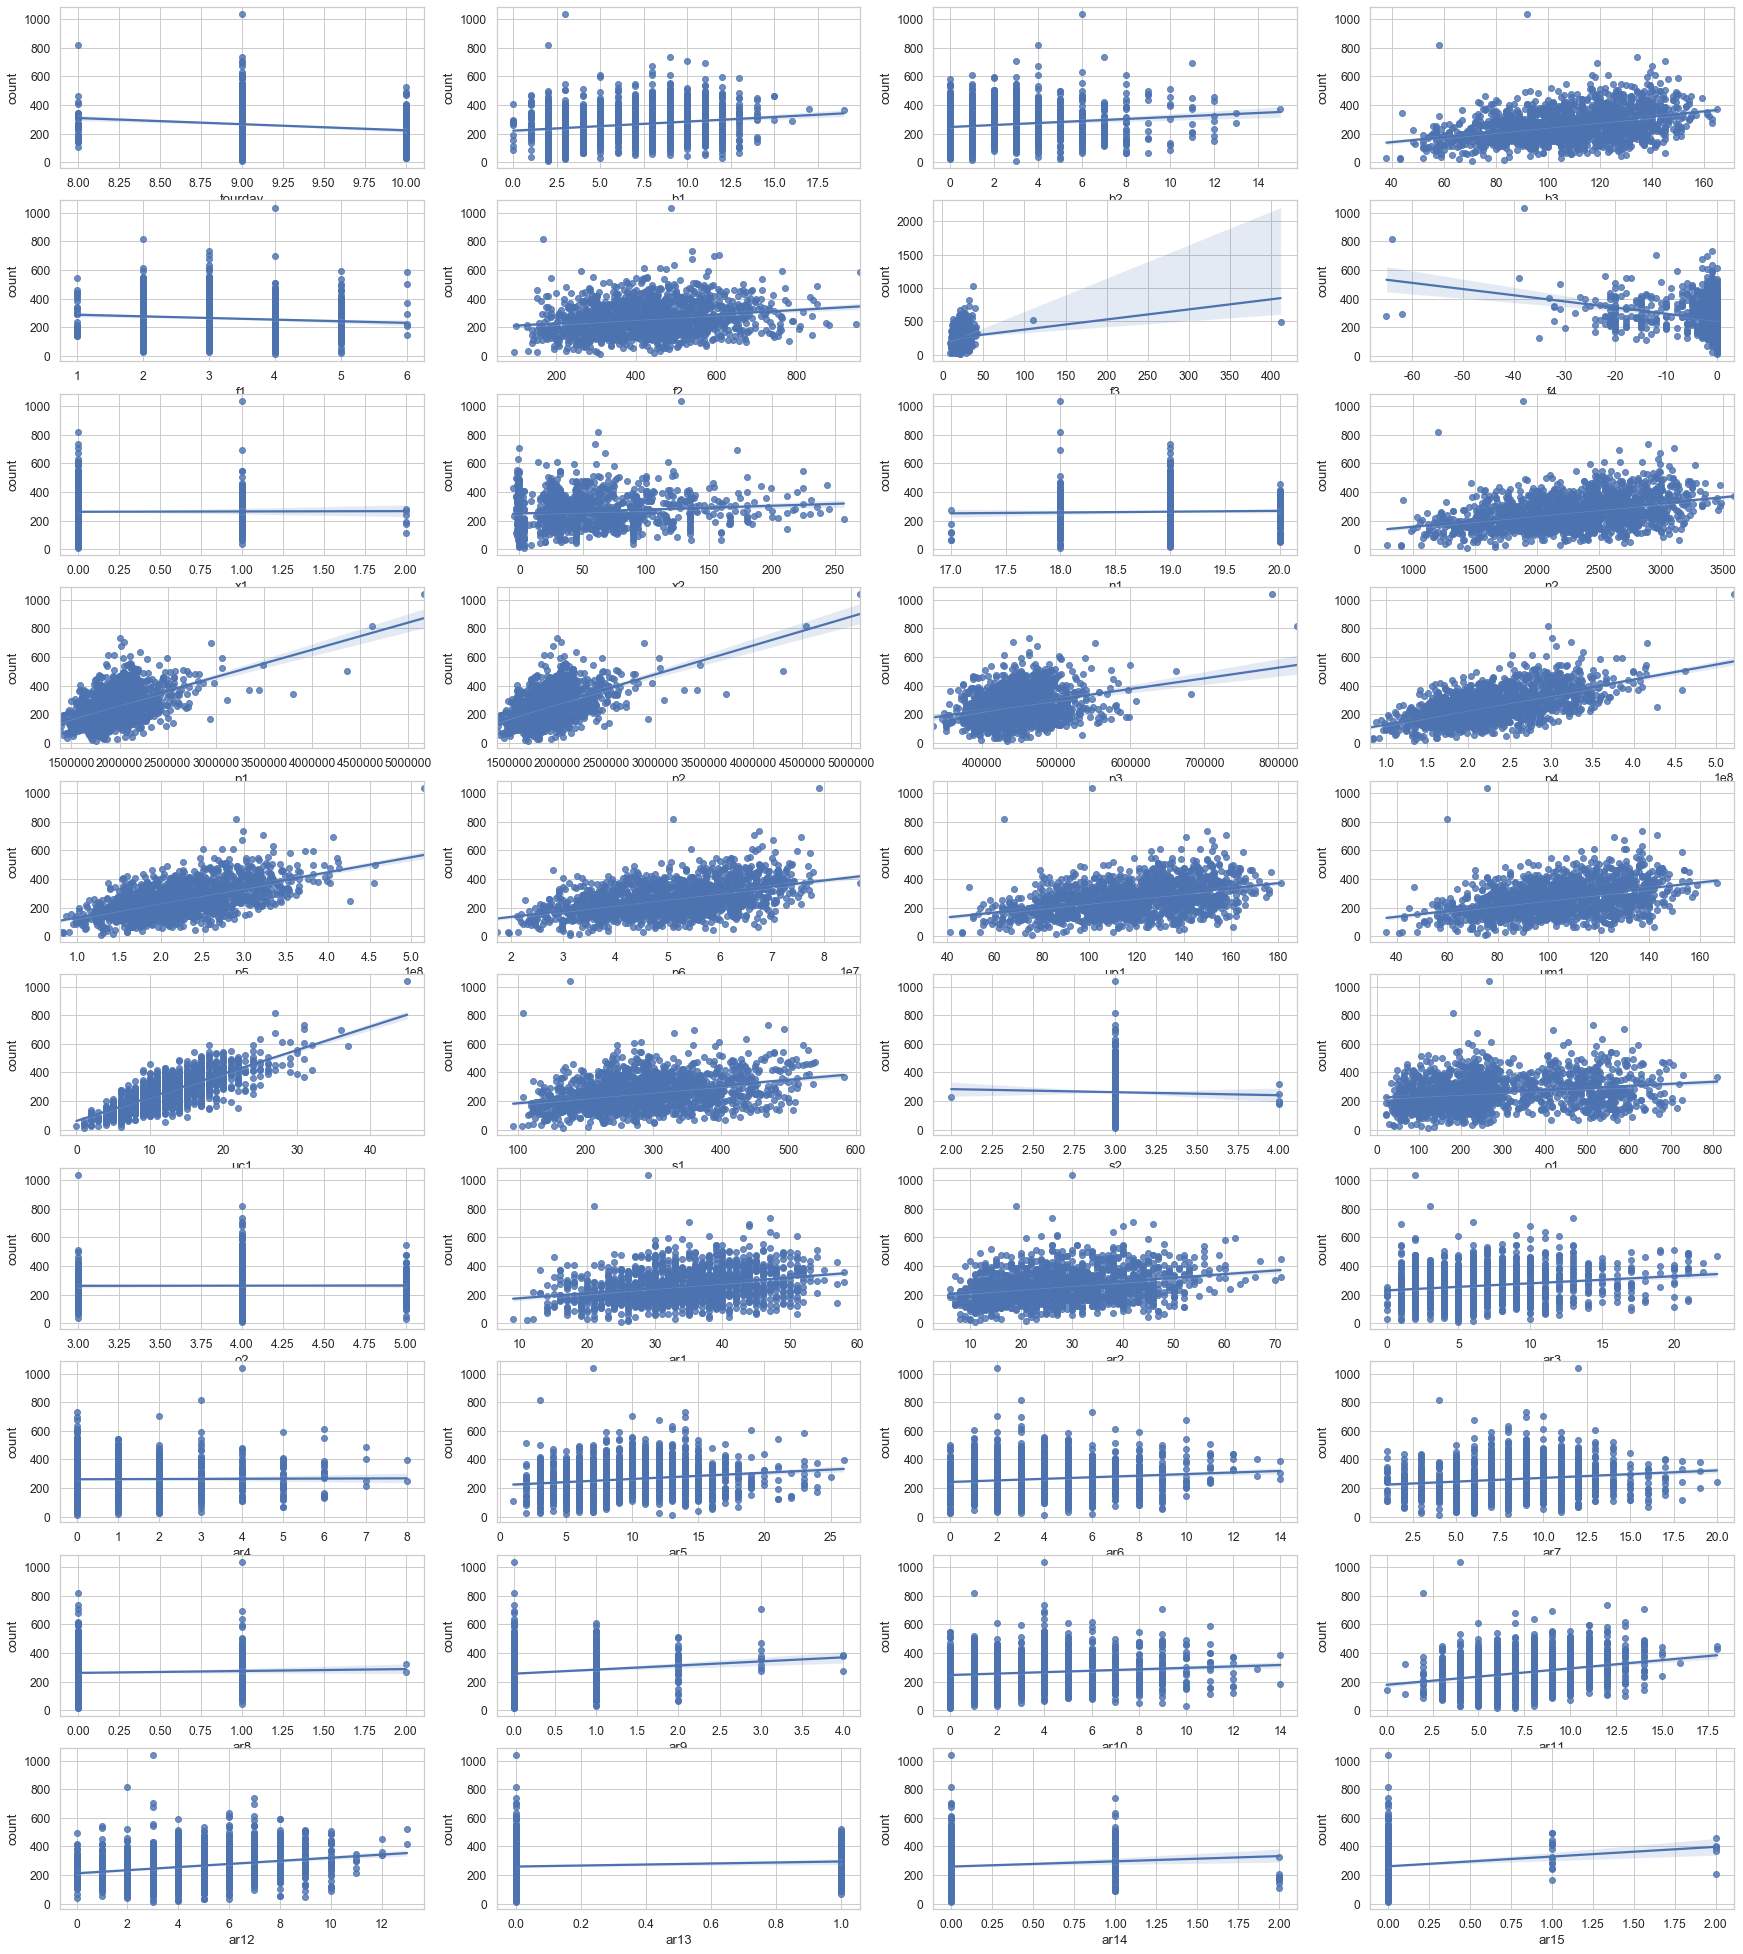

In [28]:
fig, ax = plt.subplots(10,4, figsize=(30,35))
for variable, subplot in zip(features_outclear, ax.flatten()):
    sns.regplot(x=train_outclear[variable], y=train_outclear['count'], ax=subplot)

In [29]:
num_col_outclear = train_outclear.select_dtypes(exclude=['object']).drop(['datetime','count'], axis=1).columns

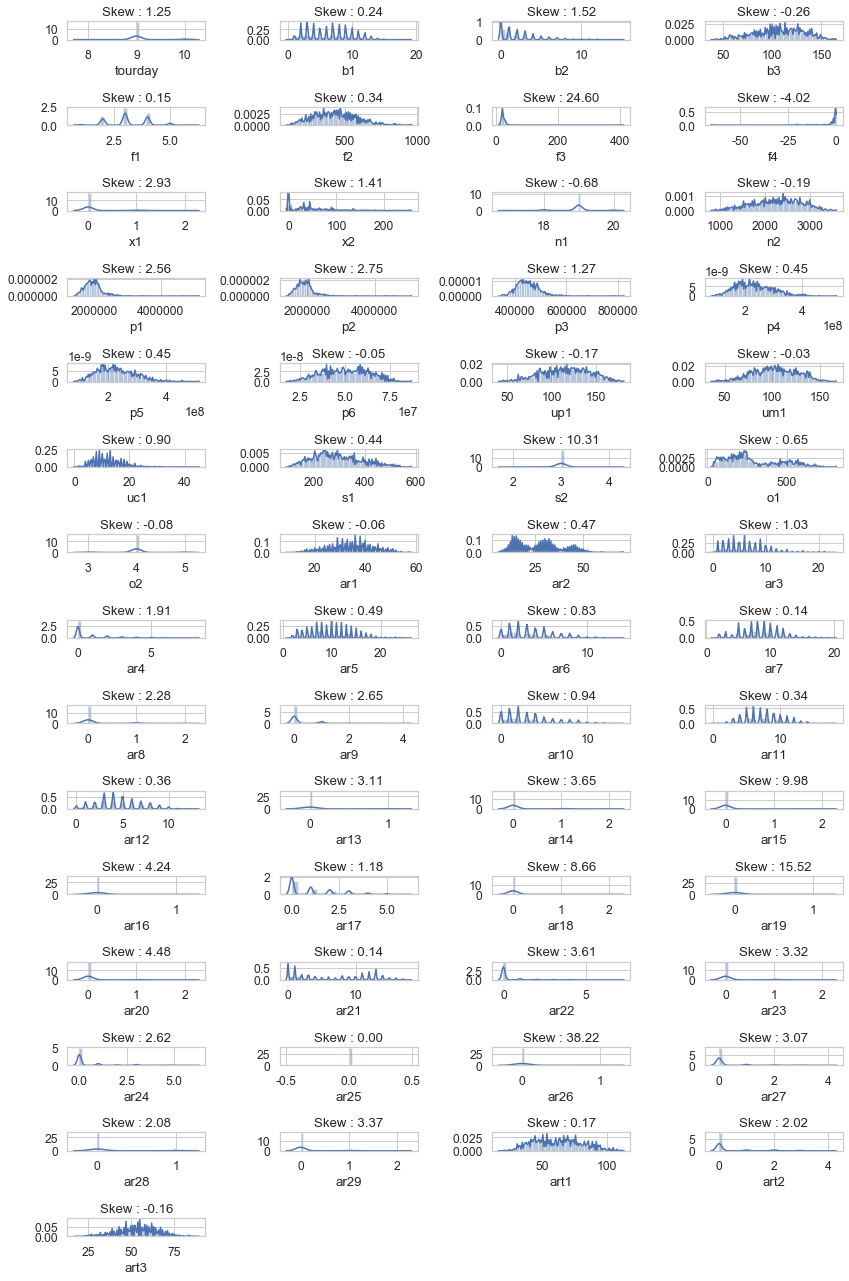

In [33]:
fig = plt.figure(figsize=(12,18))
for i in range(len(num_col_outclear)):
    fig.add_subplot(15,4,i+1)
    sns.distplot(train_outclear[num_col_outclear[i]], kde_kws={'bw': 0.1})
    plt.title('Skew : %.2f' % train_outclear[num_col_outclear[i]].skew())
    
plt.tight_layout()
plt.show()

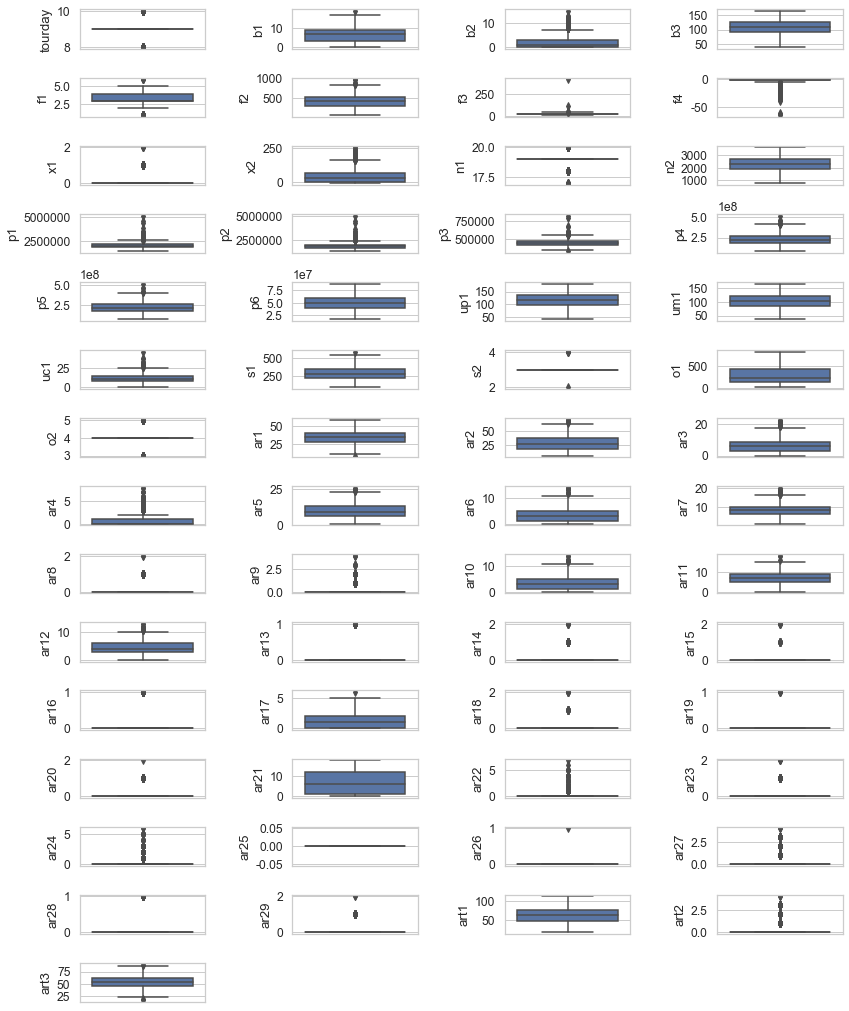

In [35]:
# Univariate analysis - boxplot
fig = plt.figure(figsize=(12,18))
for i in range(len(num_col_outclear)):
    fig.add_subplot(19,4,i+1)
    sns.boxplot(y=train_outclear[num_col_outclear[i]])
    
plt.tight_layout()
plt.show()

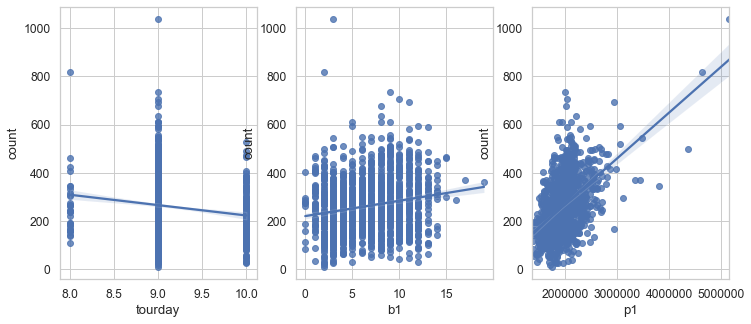

In [38]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x="tourday",y="count",data=train_outclear, ax=ax1)
sns.regplot(x="b1",y="count",data=train_outclear, ax=ax2)
sns.regplot(x="p1",y="count",data=train_outclear, ax=ax3)

### 정규화 진행

- 정규화의 경우 아웃라이어 영향을 많이 받기 때문에 의미있다고 생각되는 데이터를 제외하고 아웃라이어 즉각, 정규화 진행

In [40]:
## 트레인과 테스트 데이터를 복사하여 정규화 진행 예정
## 기존 원데이터를 사용하여 정규화 진행 후 진행 전 데이터를 비교하기 위해 데이터를 COPY하여 진행
X_train = train_outclear.copy()
X_test = test_outclear.copy()

In [41]:
X_train

datetime  tourday  b1  b2   b3  f1   f2  f3  f4  x1  ...  ar24  ar25  \
0    2015-01-01        9   2  12  101   3  456  30   0   0  ...     0     0   
1    2015-01-02        9   3   2   81   3  304  27  -1   0  ...     2     0   
2    2015-01-03        8   1   4   81   3  285  14  -1   0  ...     0     0   
3    2015-01-04        9   2   3   82   4  349  23   0   0  ...     0     0   
4    2015-01-05       10   4   5   54   3  202  20   0   1  ...     0     0   
...         ...      ...  ..  ..  ...  ..  ...  ..  ..  ..  ...   ...   ...   
1456 2018-12-27        9   7   1  117   4  602  27   0   0  ...     0     0   
1457 2018-12-28        9   3   2   99   3  396  22   0   0  ...     0     0   
1458 2018-12-29        9   8   5  113   4  541  33  -1   0  ...     0     0   
1459 2018-12-30        9   8   2  102   3  443  26  -2   0  ...     0     0   
1460 2018-12-31       10  10   1   76   4  408  22   0   0  ...     0     0   

      ar26  ar27  ar28  ar29  art1  art2  art3  count  
0        0     0     0     0    53     0    62    321  
1        0     0     0     0    44     0    42    271  
2        0     0     0     0    39     0    47    315  
3        0     0     1     0    37     0    50    271  
4        0     0     0     0    39     0    24    109  
...    ...   ...   ...   ...   ...   ...   ...    ...  
1456     0     0     0     0    76     1    48    241  
1457     0     0     0     0    42     1    61    273  
1458     0     0     0     0    73     1    52    381  
1459     0     0     1     0    54     1    57    250  
1460     0     0     0     0    38     0    49    114  

[1461 rows x 59 columns]

In [42]:
## 정규화 진행 전 datetime과 count는 제외시키고 진행해야 되기 때문에 iloc으로 해당 위치 컬럼만 불러옴
X_train.iloc[:,1:-1]

tourday  b1  b2   b3  f1   f2  f3  f4  x1  x2  ...  ar23  ar24  ar25  \
0           9   2  12  101   3  456  30   0   0   4  ...     0     0     0   
1           9   3   2   81   3  304  27  -1   0  65  ...     0     2     0   
2           8   1   4   81   3  285  14  -1   0  38  ...     0     0     0   
3           9   2   3   82   4  349  23   0   0  36  ...     0     0     0   
4          10   4   5   54   3  202  20   0   1  90  ...     0     0     0   
...       ...  ..  ..  ...  ..  ...  ..  ..  ..  ..  ...   ...   ...   ...   
1456        9   7   1  117   4  602  27   0   0  20  ...     0     0     0   
1457        9   3   2   99   3  396  22   0   0  36  ...     0     0     0   
1458        9   8   5  113   4  541  33  -1   0  19  ...     0     0     0   
1459        9   8   2  102   3  443  26  -2   0  30  ...     0     0     0   
1460       10  10   1   76   4  408  22   0   0   0  ...     0     0     0   

      ar26  ar27  ar28  ar29  art1  art2  art3  
0        0     0     0     0    53     0    62  
1        0     0     0     0    44     0    42  
2        0     0     0     0    39     0    47  
3        0     0     1     0    37     0    50  
4        0     0     0     0    39     0    24  
...    ...   ...   ...   ...   ...   ...   ...  
1456     0     0     0     0    76     1    48  
1457     0     0     0     0    42     1    61  
1458     0     0     0     0    73     1    52  
1459     0     0     1     0    54     1    57  
1460     0     0     0     0    38     0    49  

[1461 rows x 57 columns]

In [43]:
## 우선 표준정규화를 진행해볼예정
scaler = StandardScaler()

In [44]:
## datetime과 count를 제외하고 해당 feature들만 정규화 하기위해 iloc을 사용
fit_train = scaler.fit_transform(X_train.iloc[:,1:-1])

In [45]:
## 정규화된 값들의 array
fit_train

array([[-0.26671651, -1.33552104,  3.98062512, ..., -0.51266625,
        -0.47567415,  0.72289928],
       [-0.26671651, -1.0379465 , -0.09056375, ..., -1.00884236,
        -0.47567415, -1.01106205],
       [-3.05009377, -1.63309557,  0.72367402, ..., -1.28449575,
        -0.47567415, -0.57757172],
       ...,
       [-0.26671651,  0.44992618,  1.13079291, ...,  0.58994732,
         0.72876248, -0.14408139],
       [-0.26671651,  0.44992618, -0.09056375, ..., -0.45753558,
         0.72876248,  0.28940895],
       [ 2.51666075,  1.04507525, -0.49768264, ..., -1.33962643,
        -0.47567415, -0.40417558]])

In [46]:
## 정규화된 array 값들을 기존의 데이터에서 정규화 데이터로 교체 진행
X_train.iloc[:,1:-1] = fit_train

In [47]:
## 정규화가 완료된 트레인 데이터
X_train.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2015-01-01 -0.266717 -1.335521  3.980625 -0.272303 -0.180422  0.185103   
1 2015-01-02 -0.266717 -1.037946 -0.090564 -1.091819 -0.180422 -0.861253   
2 2015-01-03 -3.050094 -1.633096  0.723674 -1.091819 -0.180422 -0.992048   
3 2015-01-04 -0.266717 -1.335521  0.316555 -1.050843  0.913342 -0.551477   
4 2015-01-05  2.516661 -0.740372  1.130793 -2.198165 -0.180422 -1.563413   

         f3        f4        x1  ...      ar24  ar25      ar26     ar27  \
0  0.636180  0.441235 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
1  0.383197  0.281867 -0.330490  ...  1.576291   0.0 -0.026171 -0.37035   
2 -0.713061  0.281867 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
3  0.045887  0.441235 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
4 -0.207096  0.441235  2.784642  ... -0.446512   0.0 -0.026171 -0.37035   

       ar28      ar29      art1      art2      art3  count  
0 -0.402854 -0.284131 -0.512666 -0.475674  0.722899    321  
1 -0.402854 -0.284131 -1.008842 -0.475674 -1.011062    271  
2 -0.402854 -0.284131 -1.284496 -0.475674 -0.577572    315  
3  2.482290 -0.284131 -1.394757 -0.475674 -0.317478    271  
4 -0.402854 -0.284131 -1.284496 -0.475674 -2.571627    109  

[5 rows x 59 columns]

In [48]:
## 테스터 데이터도 진행
X_test.iloc[:,1:]

tourday  b1  b2  b3  f1   f2  f3  f4  x1  x2  ...  ar23  ar24  ar25  \
0          9   7   1  84   4  418  13   0   0  45  ...     0     0     0   
1          9   9   2  94   4  450  34   0   0  83  ...     0     0     0   
2          9   9   2  83   3  316  13   0   0  20  ...     0     0     0   
3          9   1   2  72   3  262  28   0   0  31  ...     0     1     0   
4          9   6   0  68   3  222  15   0   0  46  ...     0     0     0   
..       ...  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...   ...   ...   ...   
360        8   3   5  32   1   56  27  -4   0  38  ...     0     1     0   
361        8   5   1  22   0  -10   0  -8   0  -3  ...     0     0     0   
362        9   4   3  41   1   74  10   0   0  42  ...     0     0     0   
363       10   6   0  19   1   44  13 -15   1  31  ...     0     0     0   
364        9   5   0  47   3  183  14   0   0  -2  ...     0     0     0   

     ar26  ar27  ar28  ar29  art1  art2  art3  
0       0     0     0     0    48     1    43  
1       0     0     0     0    52     1    52  
2       0     0     0     0    52     1    41  
3       0     0     0     0    33     1    41  
4       0     0     0     0    35     1    38  
..    ...   ...   ...   ...   ...   ...   ...  
360     0     0     0     0    21     0    19  
361     0     0     0     0    17     0    11  
362     0     0     0     0    31     0    17  
363     0     0     0     0    11     0    14  
364     0     0     0     0    30     0    22  

[365 rows x 57 columns]

In [49]:
fit_test = scaler.fit_transform(X_test.iloc[:,1:])

In [50]:
fit_test

array([[-0.25668645, -0.31253813, -0.53554281, ...,  0.78829106,
        -0.08918339,  0.21360529],
       [-0.25668645,  0.2636054 , -0.03044429, ...,  1.13896289,
        -0.08918339,  0.95222989],
       [-0.25668645,  0.2636054 , -0.03044429, ...,  1.13896289,
        -0.08918339,  0.04946649],
       ...,
       [-0.25668645, -1.17675343,  0.47465422, ..., -0.70206422,
        -1.39126095, -1.92019911],
       [ 2.20885449, -0.6006099 , -1.04064133, ..., -2.45542336,
        -1.39126095, -2.16640731],
       [-0.25668645, -0.88868167, -1.04064133, ..., -0.78973217,
        -1.39126095, -1.50985211]])

In [51]:
X_test.iloc[:,1:] = fit_test

In [52]:
X_test

datetime   tourday        b1        b2        b3        f1        f2  \
0   2019-01-01 -0.256686 -0.312538 -0.535543  0.684917  0.932320  0.989744   
1   2019-01-02 -0.256686  0.263605 -0.030444  1.185909  0.932320  1.244570   
2   2019-01-03 -0.256686  0.263605 -0.030444  0.634818 -0.034432  0.177484   
3   2019-01-04 -0.256686 -2.040969 -0.030444  0.083727 -0.034432 -0.252536   
4   2019-01-05 -0.256686 -0.600610 -1.040641 -0.116669 -0.034432 -0.571069   
..         ...       ...       ...       ...       ...       ...       ...   
360 2019-12-27 -2.722227 -1.464825  1.484851 -1.920240 -1.967937 -1.892982   
361 2019-12-28 -2.722227 -0.888682 -0.535543 -2.421231 -2.934690 -2.418562   
362 2019-12-29 -0.256686 -1.176753  0.474654 -1.469347 -1.967937 -1.749642   
363 2019-12-30  2.208854 -0.600610 -1.040641 -2.571529 -1.967937 -1.988542   
364 2019-12-31 -0.256686 -0.888682 -1.040641 -1.168752 -0.034432 -0.881639   

           f3        f4        x1  ...      ar23      ar24  ar25  ar26  ar27  \
0   -1.423688  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
1    1.908394  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
2   -1.423688  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
3    0.956371  0.561462 -0.645081  ... -0.384814  1.573592   0.0   0.0   0.0   
4   -1.106347  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
..        ...       ...       ...  ...       ...       ...   ...   ...   ...   
360  0.797700 -0.090674 -0.645081  ... -0.384814  1.573592   0.0   0.0   0.0   
361 -3.486406 -0.742809 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
362 -1.899700  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
363 -1.423688 -1.884047  1.013050  ... -0.384814 -0.635489   0.0   0.0   0.0   
364 -1.265018  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   

     ar28  ar29      art1      art2      art3  
0     0.0   0.0  0.788291 -0.089183  0.213605  
1     0.0   0.0  1.138963 -0.089183  0.952230  
2     0.0   0.0  1.138963 -0.089183  0.049466  
3     0.0   0.0 -0.526728 -0.089183  0.049466  
4     0.0   0.0 -0.351392 -0.089183 -0.196742  
..    ...   ...       ...       ...       ...  
360   0.0   0.0 -1.578744 -1.391261 -1.756060  
361   0.0   0.0 -1.929416 -1.391261 -2.412616  
362   0.0   0.0 -0.702064 -1.391261 -1.920199  
363   0.0   0.0 -2.455423 -1.391261 -2.166407  
364   0.0   0.0 -0.789732 -1.391261 -1.509852  

[365 rows x 58 columns]

In [53]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()

In [55]:
MM_train = train_outclear.copy()
MM_test = test_outclear.copy()

In [56]:
MM_fit_train = scaler.fit_transform(MM_train.iloc[:,1:-1])

In [57]:
MM_fit_train

array([[-0.26671651, -1.33552104,  3.98062512, ..., -0.51266625,
        -0.47567415,  0.72289928],
       [-0.26671651, -1.0379465 , -0.09056375, ..., -1.00884236,
        -0.47567415, -1.01106205],
       [-3.05009377, -1.63309557,  0.72367402, ..., -1.28449575,
        -0.47567415, -0.57757172],
       ...,
       [-0.26671651,  0.44992618,  1.13079291, ...,  0.58994732,
         0.72876248, -0.14408139],
       [-0.26671651,  0.44992618, -0.09056375, ..., -0.45753558,
         0.72876248,  0.28940895],
       [ 2.51666075,  1.04507525, -0.49768264, ..., -1.33962643,
        -0.47567415, -0.40417558]])

In [58]:
## 정규화된 array 값들을 기존의 데이터에서 정규화 데이터로 교체 진행
MM_train.iloc[:,1:-1] = MM_fit_train

In [59]:
MM_train.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2015-01-01 -0.266717 -1.335521  3.980625 -0.272303 -0.180422  0.185103   
1 2015-01-02 -0.266717 -1.037946 -0.090564 -1.091819 -0.180422 -0.861253   
2 2015-01-03 -3.050094 -1.633096  0.723674 -1.091819 -0.180422 -0.992048   
3 2015-01-04 -0.266717 -1.335521  0.316555 -1.050843  0.913342 -0.551477   
4 2015-01-05  2.516661 -0.740372  1.130793 -2.198165 -0.180422 -1.563413   

         f3        f4        x1  ...      ar24  ar25      ar26     ar27  \
0  0.636180  0.441235 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
1  0.383197  0.281867 -0.330490  ...  1.576291   0.0 -0.026171 -0.37035   
2 -0.713061  0.281867 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
3  0.045887  0.441235 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
4 -0.207096  0.441235  2.784642  ... -0.446512   0.0 -0.026171 -0.37035   

       ar28      ar29      art1      art2      art3  count  
0 -0.402854 -0.284131 -0.512666 -0.475674  0.722899    321  
1 -0.402854 -0.284131 -1.008842 -0.475674 -1.011062    271  
2 -0.402854 -0.284131 -1.284496 -0.475674 -0.577572    315  
3  2.482290 -0.284131 -1.394757 -0.475674 -0.317478    271  
4 -0.402854 -0.284131 -1.284496 -0.475674 -2.571627    109  

[5 rows x 59 columns]

In [60]:
MM_fit_test = scaler.fit_transform(MM_test.iloc[:,1:])

In [61]:
MM_test.iloc[:,1:] = MM_fit_test

In [62]:
MM_test.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2019-01-01 -0.256686 -0.312538 -0.535543  0.684917  0.932320  0.989744   
1 2019-01-02 -0.256686  0.263605 -0.030444  1.185909  0.932320  1.244570   
2 2019-01-03 -0.256686  0.263605 -0.030444  0.634818 -0.034432  0.177484   
3 2019-01-04 -0.256686 -2.040969 -0.030444  0.083727 -0.034432 -0.252536   
4 2019-01-05 -0.256686 -0.600610 -1.040641 -0.116669 -0.034432 -0.571069   

         f3        f4        x1  ...      ar23      ar24  ar25  ar26  ar27  \
0 -1.423688  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
1  1.908394  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
2 -1.423688  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   
3  0.956371  0.561462 -0.645081  ... -0.384814  1.573592   0.0   0.0   0.0   
4 -1.106347  0.561462 -0.645081  ... -0.384814 -0.635489   0.0   0.0   0.0   

   ar28  ar29      art1      art2      art3  
0   0.0   0.0  0.788291 -0.089183  0.213605  
1   0.0   0.0  1.138963 -0.089183  0.952230  
2   0.0   0.0  1.138963 -0.089183  0.049466  
3   0.0   0.0 -0.526728 -0.089183  0.049466  
4   0.0   0.0 -0.351392 -0.089183 -0.196742  

[5 rows x 58 columns]

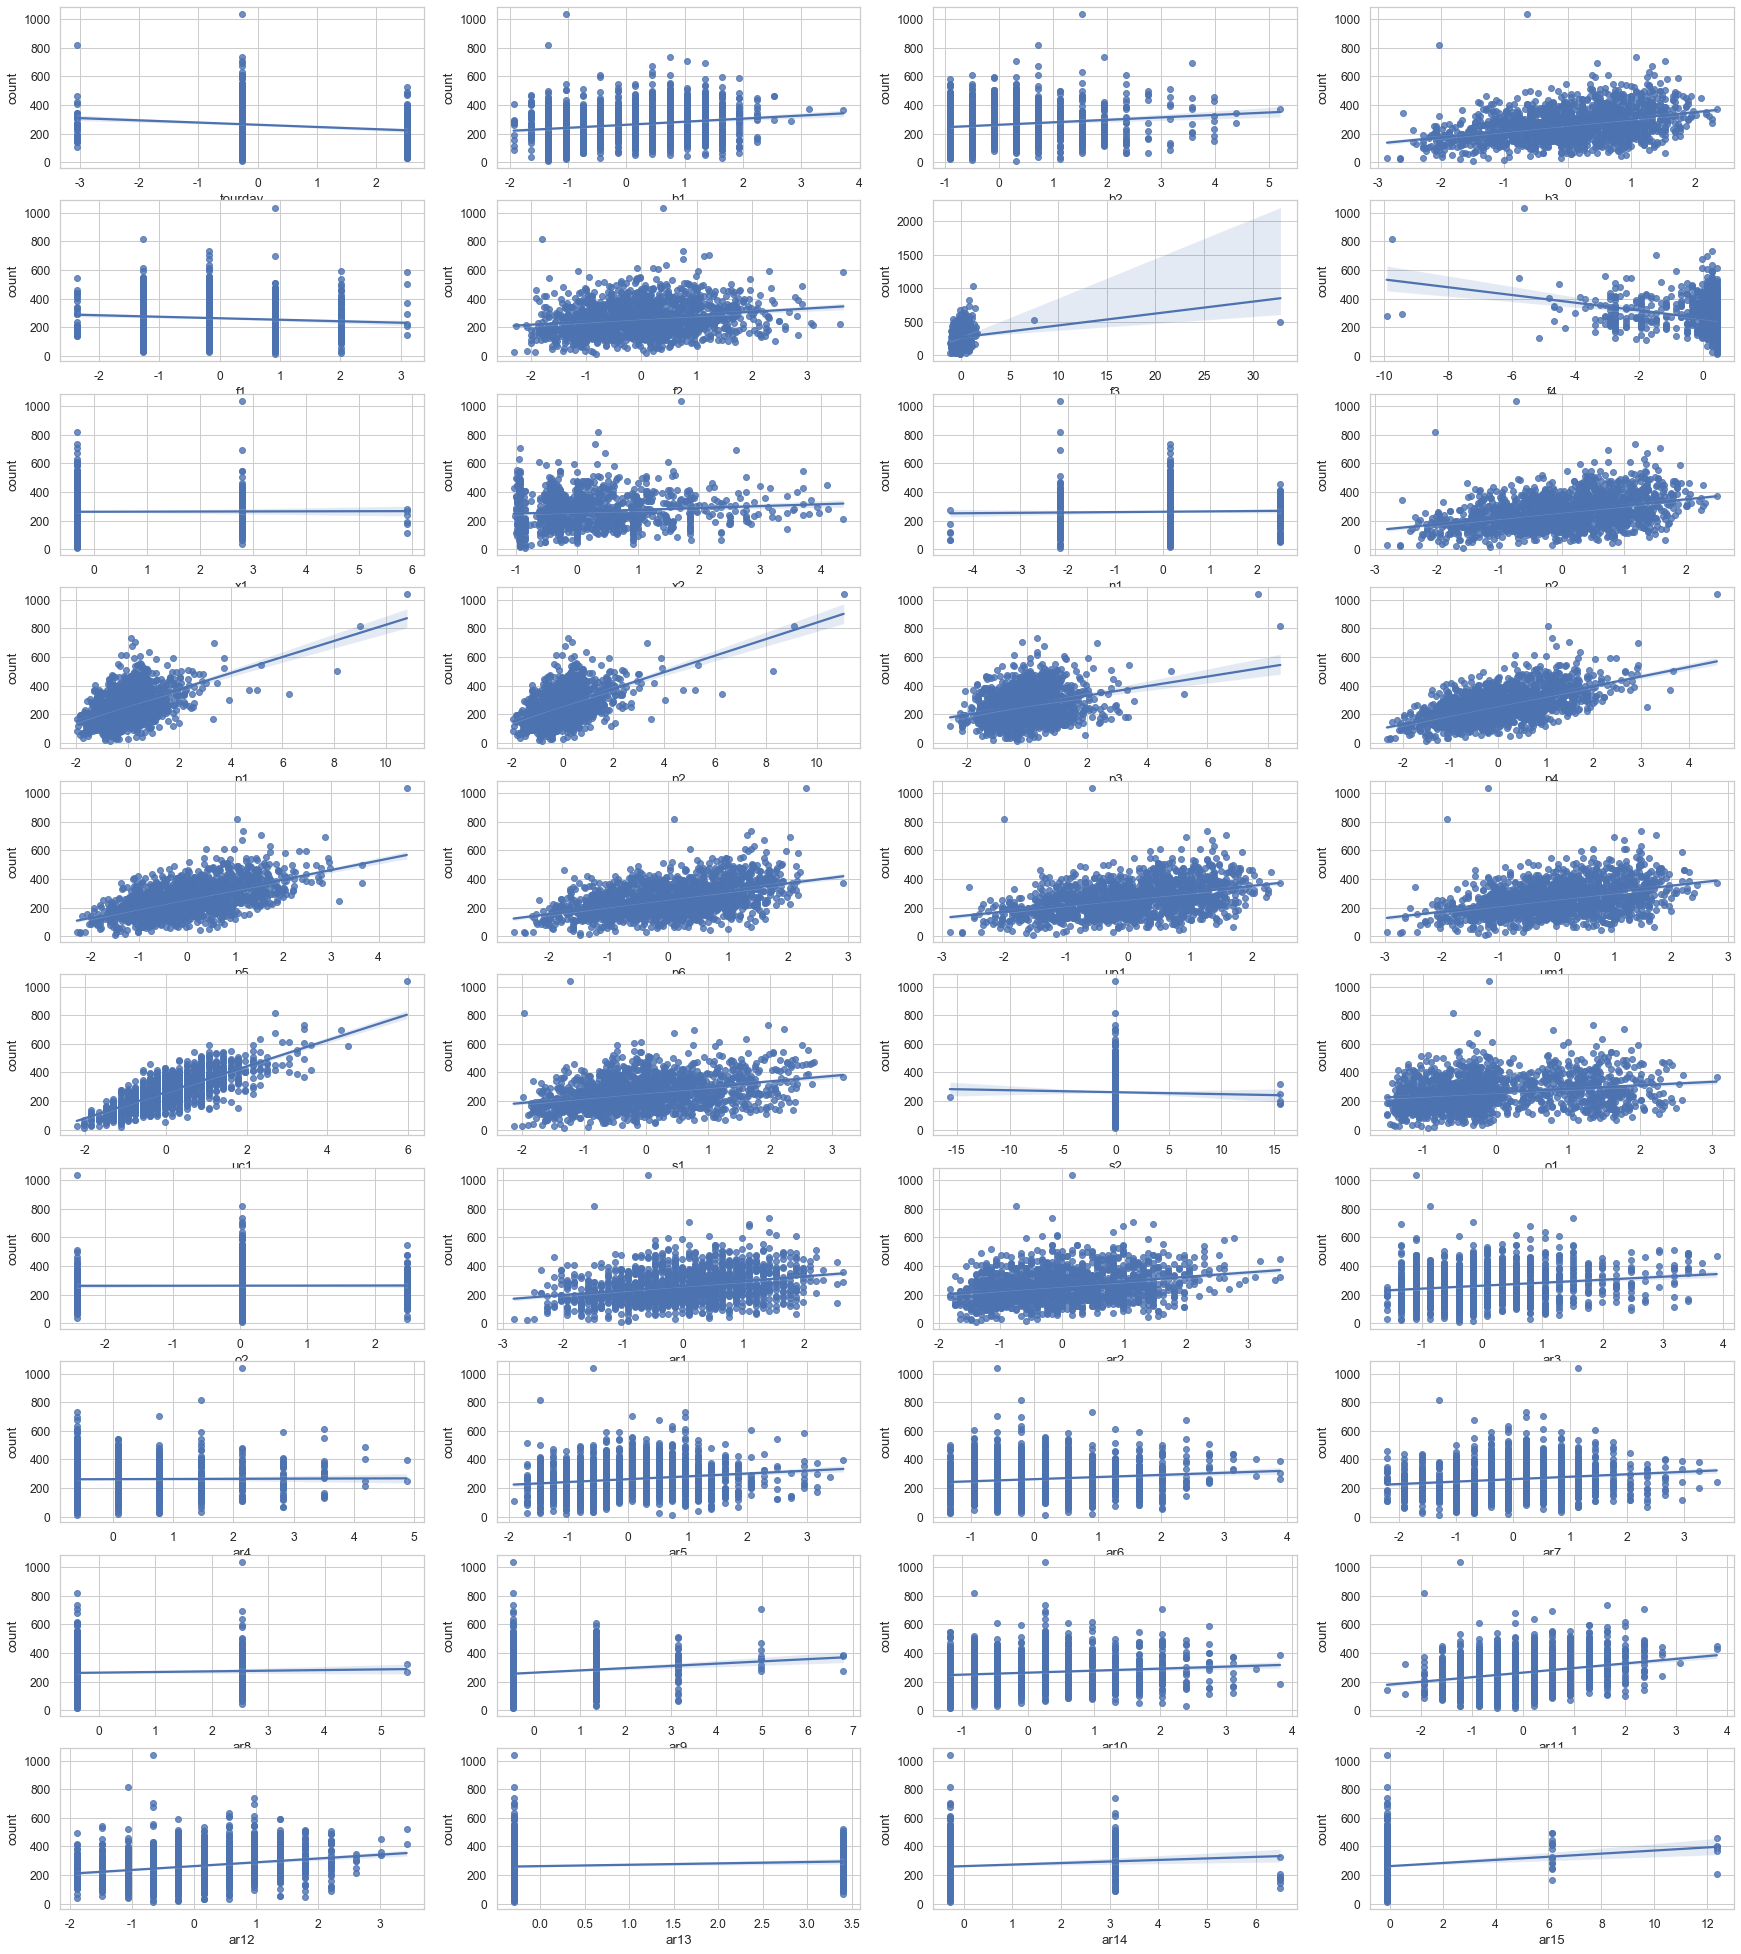

In [64]:
fig, ax = plt.subplots(10, 4, figsize=(30, 35))
for variable, subplot in zip(features_outclear, ax.flatten()):
    sns.regplot(x=X_train[variable], y=X_train['count'], ax=subplot)

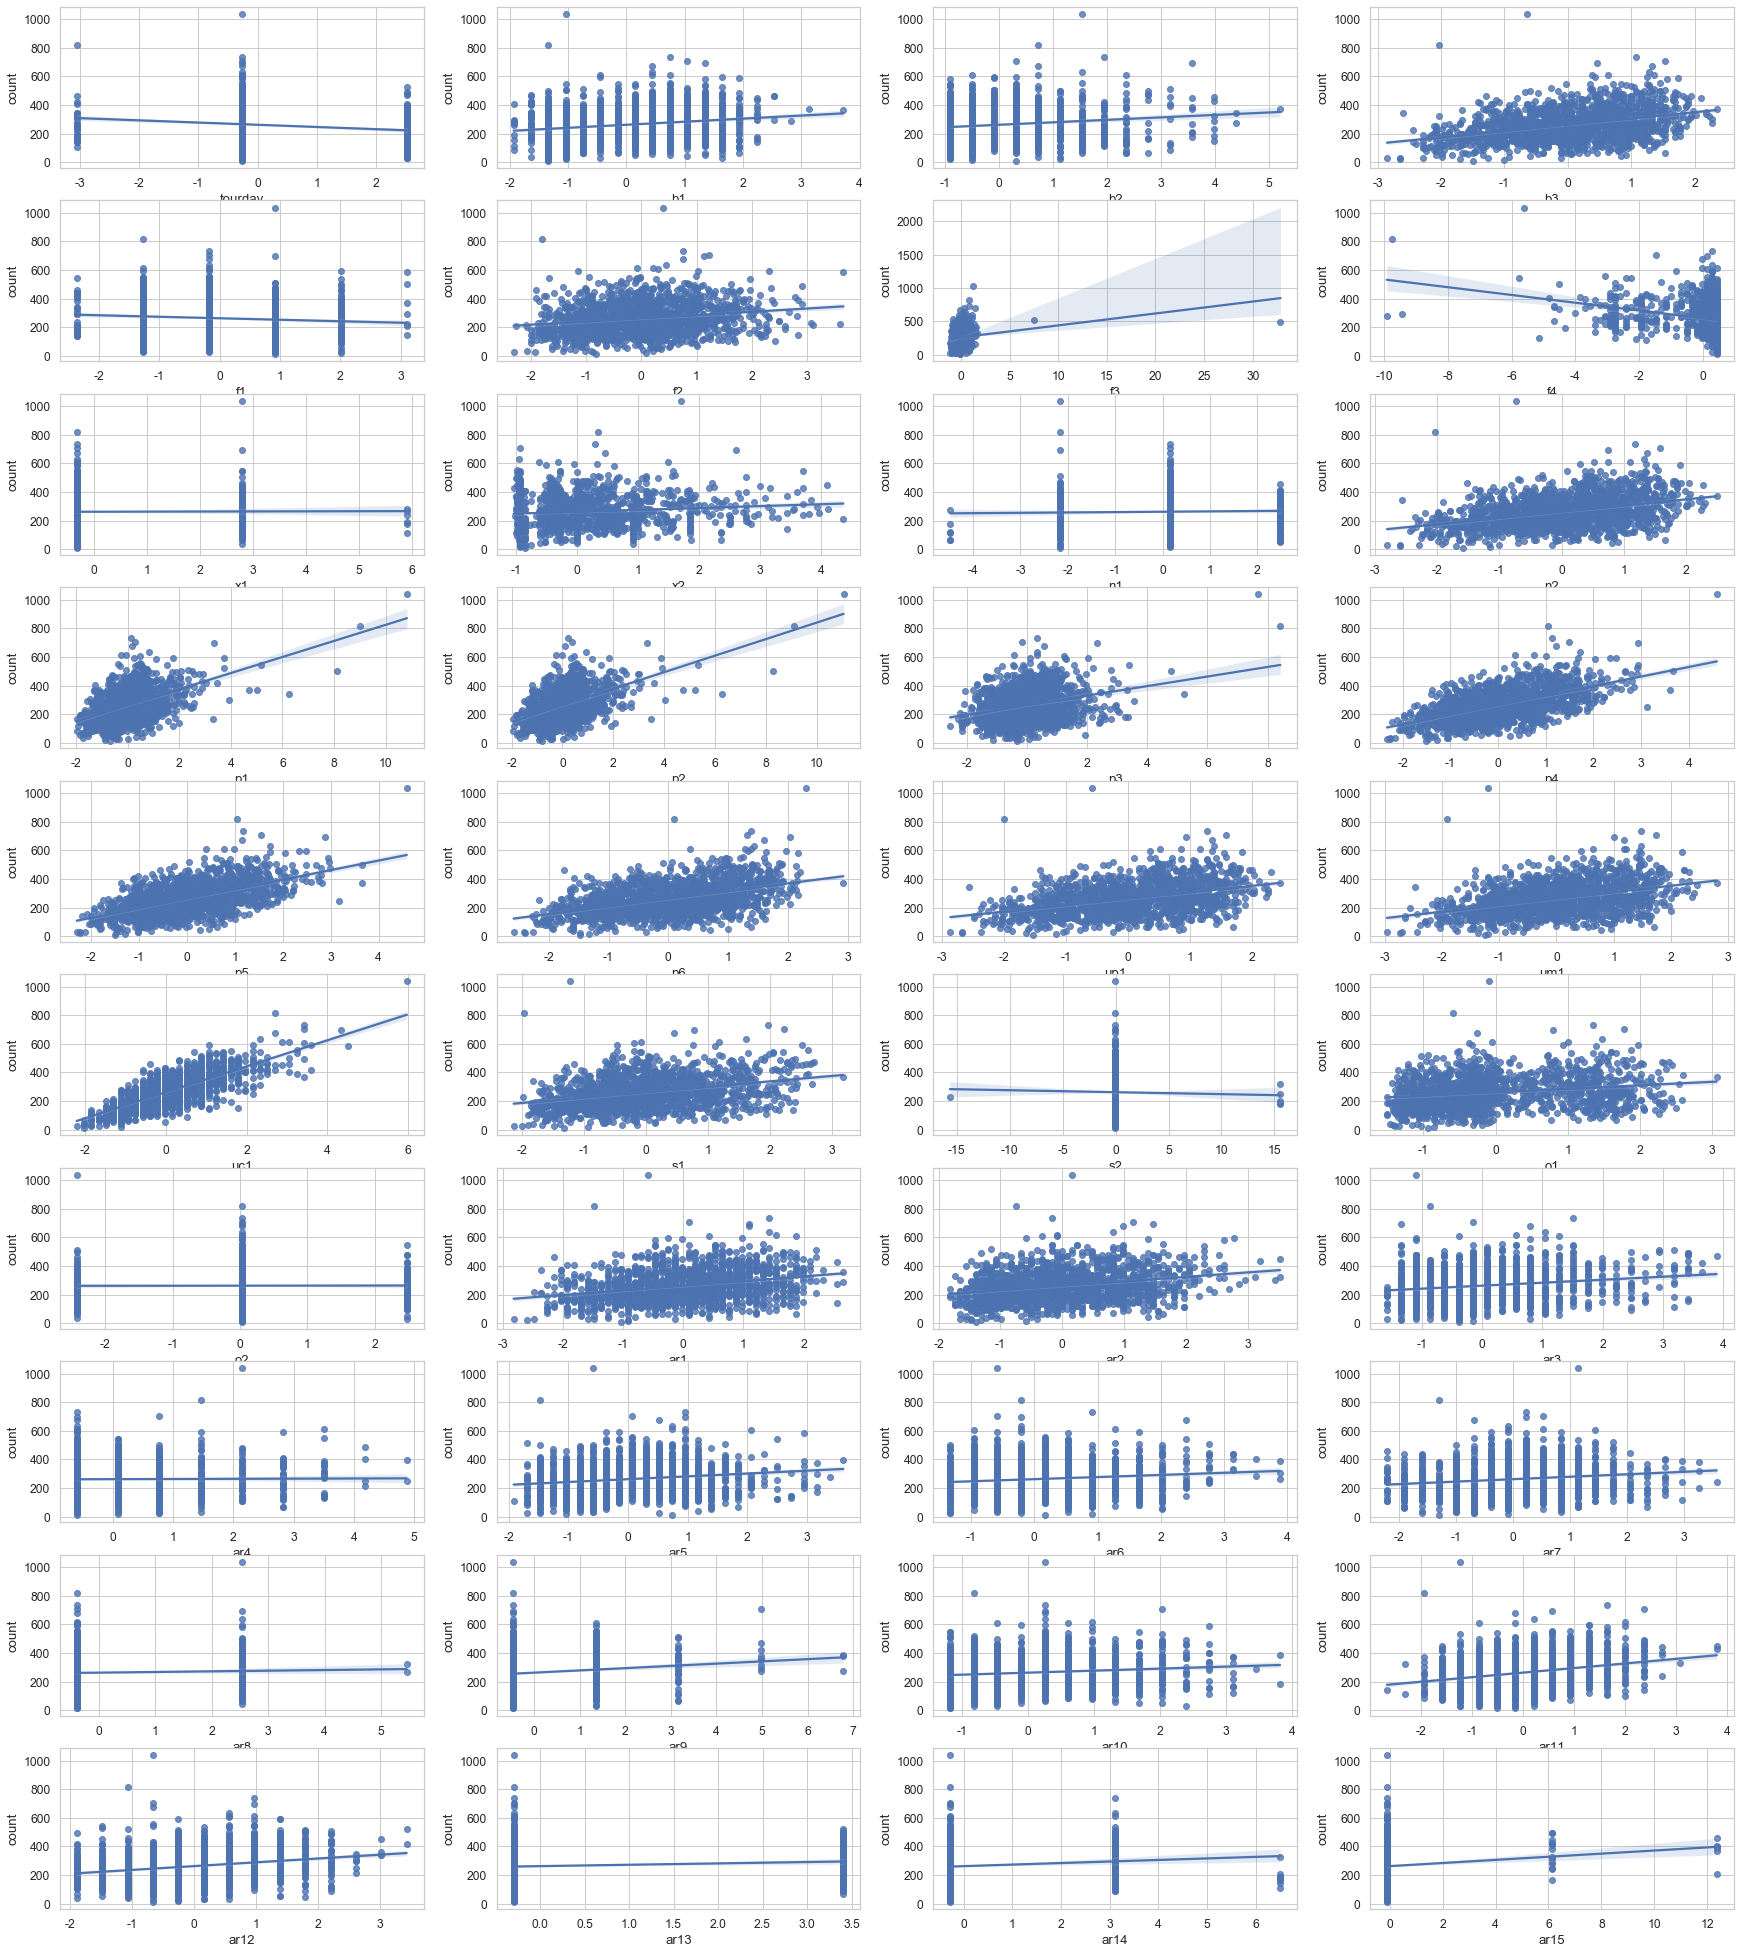

In [65]:
fig, ax = plt.subplots(10, 4, figsize=(30, 35))
for variable, subplot in zip(features_outclear, ax.flatten()):
    sns.regplot(x=MM_train[variable], y=MM_train['count'], ax=subplot)

In [102]:
X_train.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2015-01-01 -0.266717 -1.335521  3.980625 -0.272303 -0.180422  0.185103   
1 2015-01-02 -0.266717 -1.037946 -0.090564 -1.091819 -0.180422 -0.861253   
2 2015-01-03 -3.050094 -1.633096  0.723674 -1.091819 -0.180422 -0.992048   
3 2015-01-04 -0.266717 -1.335521  0.316555 -1.050843  0.913342 -0.551477   
4 2015-01-05  2.516661 -0.740372  1.130793 -2.198165 -0.180422 -1.563413   

         f3        f4        x1  ...      ar24  ar25      ar26     ar27  \
0  0.636180  0.441235 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
1  0.383197  0.281867 -0.330490  ...  1.576291   0.0 -0.026171 -0.37035   
2 -0.713061  0.281867 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
3  0.045887  0.441235 -0.330490  ... -0.446512   0.0 -0.026171 -0.37035   
4 -0.207096  0.441235  2.784642  ... -0.446512   0.0 -0.026171 -0.37035   

       ar28      ar29      art1      art2      art3  count  
0 -0.402854 -0.284131 -0.512666 -0.475674  0.722899    321  
1 -0.402854 -0.284131 -1.008842 -0.475674 -1.011062    271  
2 -0.402854 -0.284131 -1.284496 -0.475674 -0.577572    315  
3  2.482290 -0.284131 -1.394757 -0.475674 -0.317478    271  
4 -0.402854 -0.284131 -1.284496 -0.475674 -2.571627    109  

[5 rows x 59 columns]

In [103]:
X_train['year']=X_train["datetime"].dt.year
X_train['month']=X_train["datetime"].dt.month
X_train['week']=X_train["datetime"].dt.week
X_train['day']=X_train["datetime"].dt.day

X_test["year"] = X_test["datetime"].dt.year
X_test["month"] = X_test["datetime"].dt.month
X_test['week']= X_test["datetime"].dt.week
X_test["day"] = X_test["datetime"].dt.day

In [104]:
X_train.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2015-01-01 -0.266717 -1.335521  3.980625 -0.272303 -0.180422  0.185103   
1 2015-01-02 -0.266717 -1.037946 -0.090564 -1.091819 -0.180422 -0.861253   
2 2015-01-03 -3.050094 -1.633096  0.723674 -1.091819 -0.180422 -0.992048   
3 2015-01-04 -0.266717 -1.335521  0.316555 -1.050843  0.913342 -0.551477   
4 2015-01-05  2.516661 -0.740372  1.130793 -2.198165 -0.180422 -1.563413   

         f3        f4        x1  ...      ar28      ar29      art1      art2  \
0  0.636180  0.441235 -0.330490  ... -0.402854 -0.284131 -0.512666 -0.475674   
1  0.383197  0.281867 -0.330490  ... -0.402854 -0.284131 -1.008842 -0.475674   
2 -0.713061  0.281867 -0.330490  ... -0.402854 -0.284131 -1.284496 -0.475674   
3  0.045887  0.441235 -0.330490  ...  2.482290 -0.284131 -1.394757 -0.475674   
4 -0.207096  0.441235  2.784642  ... -0.402854 -0.284131 -1.284496 -0.475674   

       art3  count  year  month  week  day  
0  0.722899    321  2015      1     1    1  
1 -1.011062    271  2015      1     1    2  
2 -0.577572    315  2015      1     1    3  
3 -0.317478    271  2015      1     1    4  
4 -2.571627    109  2015      1     2    5  

[5 rows x 63 columns]

In [111]:
X_train["dayofweek"] = X_train["datetime"].dt.dayofweek
X_test["dayofweek"] = X_test["datetime"].dt.dayofweek

In [105]:
def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

X_train['season'] = X_train.month.apply(badToRight)

In [112]:
X_train.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2015-01-01 -0.266717 -1.335521  3.980625 -0.272303 -0.180422  0.185103   
1 2015-01-02 -0.266717 -1.037946 -0.090564 -1.091819 -0.180422 -0.861253   
2 2015-01-03 -3.050094 -1.633096  0.723674 -1.091819 -0.180422 -0.992048   
3 2015-01-04 -0.266717 -1.335521  0.316555 -1.050843  0.913342 -0.551477   
4 2015-01-05  2.516661 -0.740372  1.130793 -2.198165 -0.180422 -1.563413   

         f3        f4        x1  ...      art1      art2      art3  count  \
0  0.636180  0.441235 -0.330490  ... -0.512666 -0.475674  0.722899    321   
1  0.383197  0.281867 -0.330490  ... -1.008842 -0.475674 -1.011062    271   
2 -0.713061  0.281867 -0.330490  ... -1.284496 -0.475674 -0.577572    315   
3  0.045887  0.441235 -0.330490  ... -1.394757 -0.475674 -0.317478    271   
4 -0.207096  0.441235  2.784642  ... -1.284496 -0.475674 -2.571627    109   

   year  month  week  day  season  dayofweek  
0  2015      1     1    1       4          3  
1  2015      1     1    2       4          4  
2  2015      1     1    3       4          5  
3  2015      1     1    4       4          6  
4  2015      1     2    5       4          0  

[5 rows x 65 columns]

In [108]:
def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

X_test['season'] = X_test.month.apply(badToRight)

In [113]:
X_test.head()

datetime   tourday        b1        b2        b3        f1        f2  \
0 2019-01-01 -0.256686 -0.312538 -0.535543  0.684917  0.932320  0.989744   
1 2019-01-02 -0.256686  0.263605 -0.030444  1.185909  0.932320  1.244570   
2 2019-01-03 -0.256686  0.263605 -0.030444  0.634818 -0.034432  0.177484   
3 2019-01-04 -0.256686 -2.040969 -0.030444  0.083727 -0.034432 -0.252536   
4 2019-01-05 -0.256686 -0.600610 -1.040641 -0.116669 -0.034432 -0.571069   

         f3        f4        x1  ...  ar29      art1      art2      art3  \
0 -1.423688  0.561462 -0.645081  ...   0.0  0.788291 -0.089183  0.213605   
1  1.908394  0.561462 -0.645081  ...   0.0  1.138963 -0.089183  0.952230   
2 -1.423688  0.561462 -0.645081  ...   0.0  1.138963 -0.089183  0.049466   
3  0.956371  0.561462 -0.645081  ...   0.0 -0.526728 -0.089183  0.049466   
4 -1.106347  0.561462 -0.645081  ...   0.0 -0.351392 -0.089183 -0.196742   

   year  month  week  day  season  dayofweek  
0  2019      1     1    1       4          1  
1  2019      1     1    2       4          2  
2  2019      1     1    3       4          3  
3  2019      1     1    4       4          4  
4  2019      1     1    5       4          5  

[5 rows x 64 columns]

## VIF 분석을 통한 다중공선성 변수 파악 및 제외할 변수 파악

In [110]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [114]:
features_1 = "tourday+b1+b2+b3+f1+f2+f3+f4+x1+x2+n1+n2+p1+p2+p3+p4+p5+p6+up1+um1+uc1+s1+s2+o1+o2+ar1+ar2+ar3+ar4+ar5+ar6+ar7+ar8+ar9+ar10+ar11+ar12+ar13+ar14+ar15+ar16+ar17+ar18+ar19+ar20+ar21+ar22+ar23+ar24+ar25+ar26+ar27+ar28+ar29+art1+art2+art3+year+month+week+day+season+dayofweek"

In [115]:
# Break into left and right hand side; y and X
y, X = dmatrices("count ~" + features_1, data=X_train, return_type="dataframe")

# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Fit X to y
result = sm.OLS(y, X).fit()

In [116]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     108.6
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:30:54   Log-Likelihood:                -7765.3
No. Observations:                1461   AIC:                         1.565e+04
Df Residuals:                    1403   BIC:                         1.595e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.035e+04   9793.565      1.057      0.2

In [117]:
vif = pd.DataFrame()

In [118]:
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [119]:
vif["features_1"] = X.columns

In [141]:
vif.round(1).iloc[5:]

VIF Factor features_1
5          7.6         f1
6         17.6         f2
7          1.1         f3
8          1.2         f4
9          2.5         x1
10         3.3         x2
11         3.1         n1
12       984.5         n2
13      4556.2         p1
14      4615.2         p2
15        30.7         p3
16     20471.9         p4
17     21274.7         p5
18       172.3         p6
19         inf        up1
20        72.8        um1
21         2.6        uc1
22        24.8         s1
23         1.1         s2
24        27.0         o1
25         1.8         o2
26         inf        ar1
27         inf        ar2
28         inf        ar3
29         inf        ar4
30         inf        ar5
31         inf        ar6
32         inf        ar7
33         inf        ar8
34         inf        ar9
35         inf       ar10
36         inf       ar11
37         inf       ar12
38         inf       ar13
39         inf       ar14
40         inf       ar15
41         inf       ar16
42         inf       ar17
43         inf       ar18
44         inf       ar19
45         inf       ar20
46         inf       ar21
47         inf       ar22
48         inf       ar23
49         inf       ar24
50         NaN       ar25
51         inf       ar26
52         inf       ar27
53         inf       ar28
54         inf       ar29
55         inf       art1
56         inf       art2
57         inf       art3
58        17.1       year
59        26.5      month
60        25.8       week
61         1.2        day
62         1.8     season
63         7.2  dayofweek

### 순서

1. VIF 계수가 높은 feature제거

2. 단 유사한 feature의 경우, 둘 중 1개만 제거(FIP, kFIP의 경우) 상관관계가 가장 높은것을 남겨둠

3. 제거 후 VIF계수 재출력

4. (1, 2, 3)의 과정 반복

5. 회귀분석 진행

6. feature의 p-value점검

In [202]:
X_train[['f2','n2','p1','p2','p3','p4','p5','p6','up1','um1','s1','o1','count']].corr(method = 'pearson')

f2        n2        p1        p2        p3        p4        p5  \
f2     1.000000  0.729959  0.022242  0.034513 -0.107957  0.618164  0.617885   
n2     0.729959  1.000000  0.028380  0.059896  0.024308  0.841590  0.848686   
p1     0.022242  0.028380  1.000000  0.996620  0.651208  0.546125  0.534606   
p2     0.034513  0.059896  0.996620  1.000000  0.649278  0.570006  0.561554   
p3    -0.107957  0.024308  0.651208  0.649278  1.000000  0.343724  0.336936   
p4     0.618164  0.841590  0.546125  0.570006  0.343724  1.000000  0.999168   
p5     0.617885  0.848686  0.534606  0.561554  0.336936  0.999168  1.000000   
p6     0.625216  0.914139  0.287252  0.312029  0.404701  0.910587  0.912441   
up1    0.738713  0.997155  0.047211  0.076602  0.023754  0.853331  0.859120   
um1    0.722998  0.978179  0.072382  0.102008  0.035100  0.852925  0.859068   
s1     0.607812  0.826489 -0.017484  0.029056 -0.113974  0.673509  0.691744   
o1     0.480769  0.659152 -0.071723 -0.017660 -0.117967  0.496391  0.521398   
count  0.197772  0.379038  0.490146  0.503864  0.291757  0.583336  0.581668   

             p6       up1       um1        s1        o1     count  
f2     0.625216  0.738713  0.722998  0.607812  0.480769  0.197772  
n2     0.914139  0.997155  0.978179  0.826489  0.659152  0.379038  
p1     0.287252  0.047211  0.072382 -0.017484 -0.071723  0.490146  
p2     0.312029  0.076602  0.102008  0.029056 -0.017660  0.503864  
p3     0.404701  0.023754  0.035100 -0.113974 -0.117967  0.291757  
p4     0.910587  0.853331  0.852925  0.673509  0.496391  0.583336  
p5     0.912441  0.859120  0.859068  0.691744  0.521398  0.581668  
p6     1.000000  0.915954  0.901418  0.679506  0.512777  0.468949  
up1    0.915954  1.000000  0.984159  0.822363  0.649495  0.392947  
um1    0.901418  0.984159  1.000000  0.840642  0.674528  0.395540  
s1     0.679506  0.822363  0.840642  1.000000  0.913689  0.330110  
o1     0.512777  0.649495  0.674528  0.913689  1.000000  0.210145  
count  0.468949  0.392947  0.395540  0.330110  0.210145  1.000000

In [156]:
features_2 = "tourday+b1+b2+b3+f1+f2+f3+f4+x1+x2+n1+n2+p1+p3+p4+p6+up1+um1+uc1+s1+s2+o1+o2+ar1+ar2+ar3+ar4+ar5+ar6+ar7+ar8+ar9+ar10+ar11+ar12+ar13+ar14+ar15+ar16+ar17+ar18+ar19+ar20+ar21+ar22+ar23+ar24+ar25+ar26+ar27+ar28+ar29+art1+art2+art3+year+month+week+day+season+dayofweek"

In [158]:
# Break into left and right hand side; y and X
y, X = dmatrices("count ~" + features_2, data=X_train, return_type="dataframe")

# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Fit X to y
result_2 = sm.OLS(y, X).fit()

In [159]:
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     109.9
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:24:13   Log-Likelihood:                -7780.2
No. Observations:                1461   AIC:                         1.567e+04
Df Residuals:                    1405   BIC:                         1.597e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2971.0624   9098.695      0.327      0.7

In [160]:
vif_2 = pd.DataFrame()

In [161]:
vif_2["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [162]:
vif_2["features_2"] = X.columns

In [209]:
vif_2.round(1)

VIF Factor features_2
0   47058696.2  Intercept
1          1.9    tourday
2          inf         b1
3          inf         b2
4          inf         b3
..         ...        ...
57        26.4      month
58        25.8       week
59         1.2        day
60         1.7     season
61         7.2  dayofweek

[62 rows x 2 columns]

### 순서

1. VIF 계수가 높은 feature제거

2. 단 유사한 feature의 경우, 둘 중 1개만 제거(FIP, kFIP의 경우)

3. 제거 후 VIF계수 재출력

4. (1, 2, 3)의 과정 반복

5. 회귀분석 진행

6. feature의 p-value점검

In [128]:
##피어슨 상관계수를 통한 상관관계 측정
X_train.corr(method = 'pearson')

tourday        b1        b2        b3        f1        f2  \
tourday    1.000000  0.087689 -0.159887 -0.302369 -0.106467 -0.238353   
b1         0.087689  1.000000 -0.133471  0.523027 -0.089916  0.357687   
b2        -0.159887 -0.133471  1.000000 -0.026956  0.055590  0.077079   
b3        -0.302369  0.523027 -0.026956  1.000000  0.105632  0.739979   
f1        -0.106467 -0.089916  0.055590  0.105632  1.000000  0.688675   
...             ...       ...       ...       ...       ...       ...   
month      0.008170  0.064561 -0.151821  0.113048  0.073584  0.108908   
week       0.007125  0.051907 -0.154887  0.100630  0.081726  0.105788   
day       -0.012805  0.024690 -0.058237  0.031552  0.063137  0.062100   
season    -0.018422 -0.072276 -0.015147 -0.211486  0.011770 -0.125056   
dayofweek -0.482145 -0.182904 -0.039374  0.249620  0.073911  0.167896   

                 f3        f4        x1        x2  ...      art1      art2  \
tourday   -0.026479 -0.037766  0.012743 -0.128255  ... -0.266554  0.100295   
b1         0.139363 -0.017527 -0.140630 -0.142105  ...  0.620295  0.214754   
b2         0.034774 -0.024700  0.062952  0.092714  ...  0.041752 -0.022941   
b3         0.143332  0.018978 -0.113670  0.072067  ...  0.912887  0.000763   
f1         0.182331  0.144274 -0.127259 -0.072700  ...  0.102725 -0.152547   
...             ...       ...       ...       ...  ...       ...       ...   
month      0.009452  0.033915 -0.055058  0.052461  ...  0.091850  0.168830   
week       0.006645  0.034166 -0.047925  0.055313  ...  0.081899  0.164729   
day       -0.005726 -0.032000  0.012092  0.000262  ...  0.010836 -0.014614   
season    -0.035668  0.122831  0.005394 -0.054361  ... -0.152913  0.091095   
dayofweek -0.008897  0.066539 -0.049367  0.019517  ...  0.121515 -0.090324   

               art3     count      year     month      week       day  \
tourday   -0.236303 -0.134524  0.051215  0.008170  0.007125 -0.012805   
b1         0.378636  0.186886  0.643210  0.064561  0.051907  0.024690   
b2         0.053027  0.150091 -0.186080 -0.151821 -0.154887 -0.058237   
b3         0.826826  0.383107  0.413593  0.113048  0.100630  0.031552   
f1         0.058577 -0.090958 -0.195858  0.073584  0.081726  0.063137   
...             ...       ...       ...       ...       ...       ...   
month      0.069074 -0.146204  0.000402  1.000000  0.977260  0.010522   
week       0.054405 -0.152818 -0.013259  0.977260  1.000000  0.074487   
day        0.045561  0.041825 -0.000462  0.010522  0.074487  1.000000   
season    -0.237839 -0.414769 -0.000413  0.206190  0.219022 -0.012246   
dayofweek  0.281890  0.107310 -0.001377  0.003317 -0.001749 -0.004051   

             season  dayofweek  
tourday   -0.018422  -0.482145  
b1        -0.072276  -0.182904  
b2        -0.015147  -0.039374  
b3        -0.211486   0.249620  
f1         0.011770   0.073911  
...             ...        ...  
month      0.206190   0.003317  
week       0.219022  -0.001749  
day       -0.012246  -0.004051  
season     1.000000   0.003224  
dayofweek  0.003224   1.000000  

[64 rows x 64 columns]

<Figure size 3240x1800 with 0 Axes>

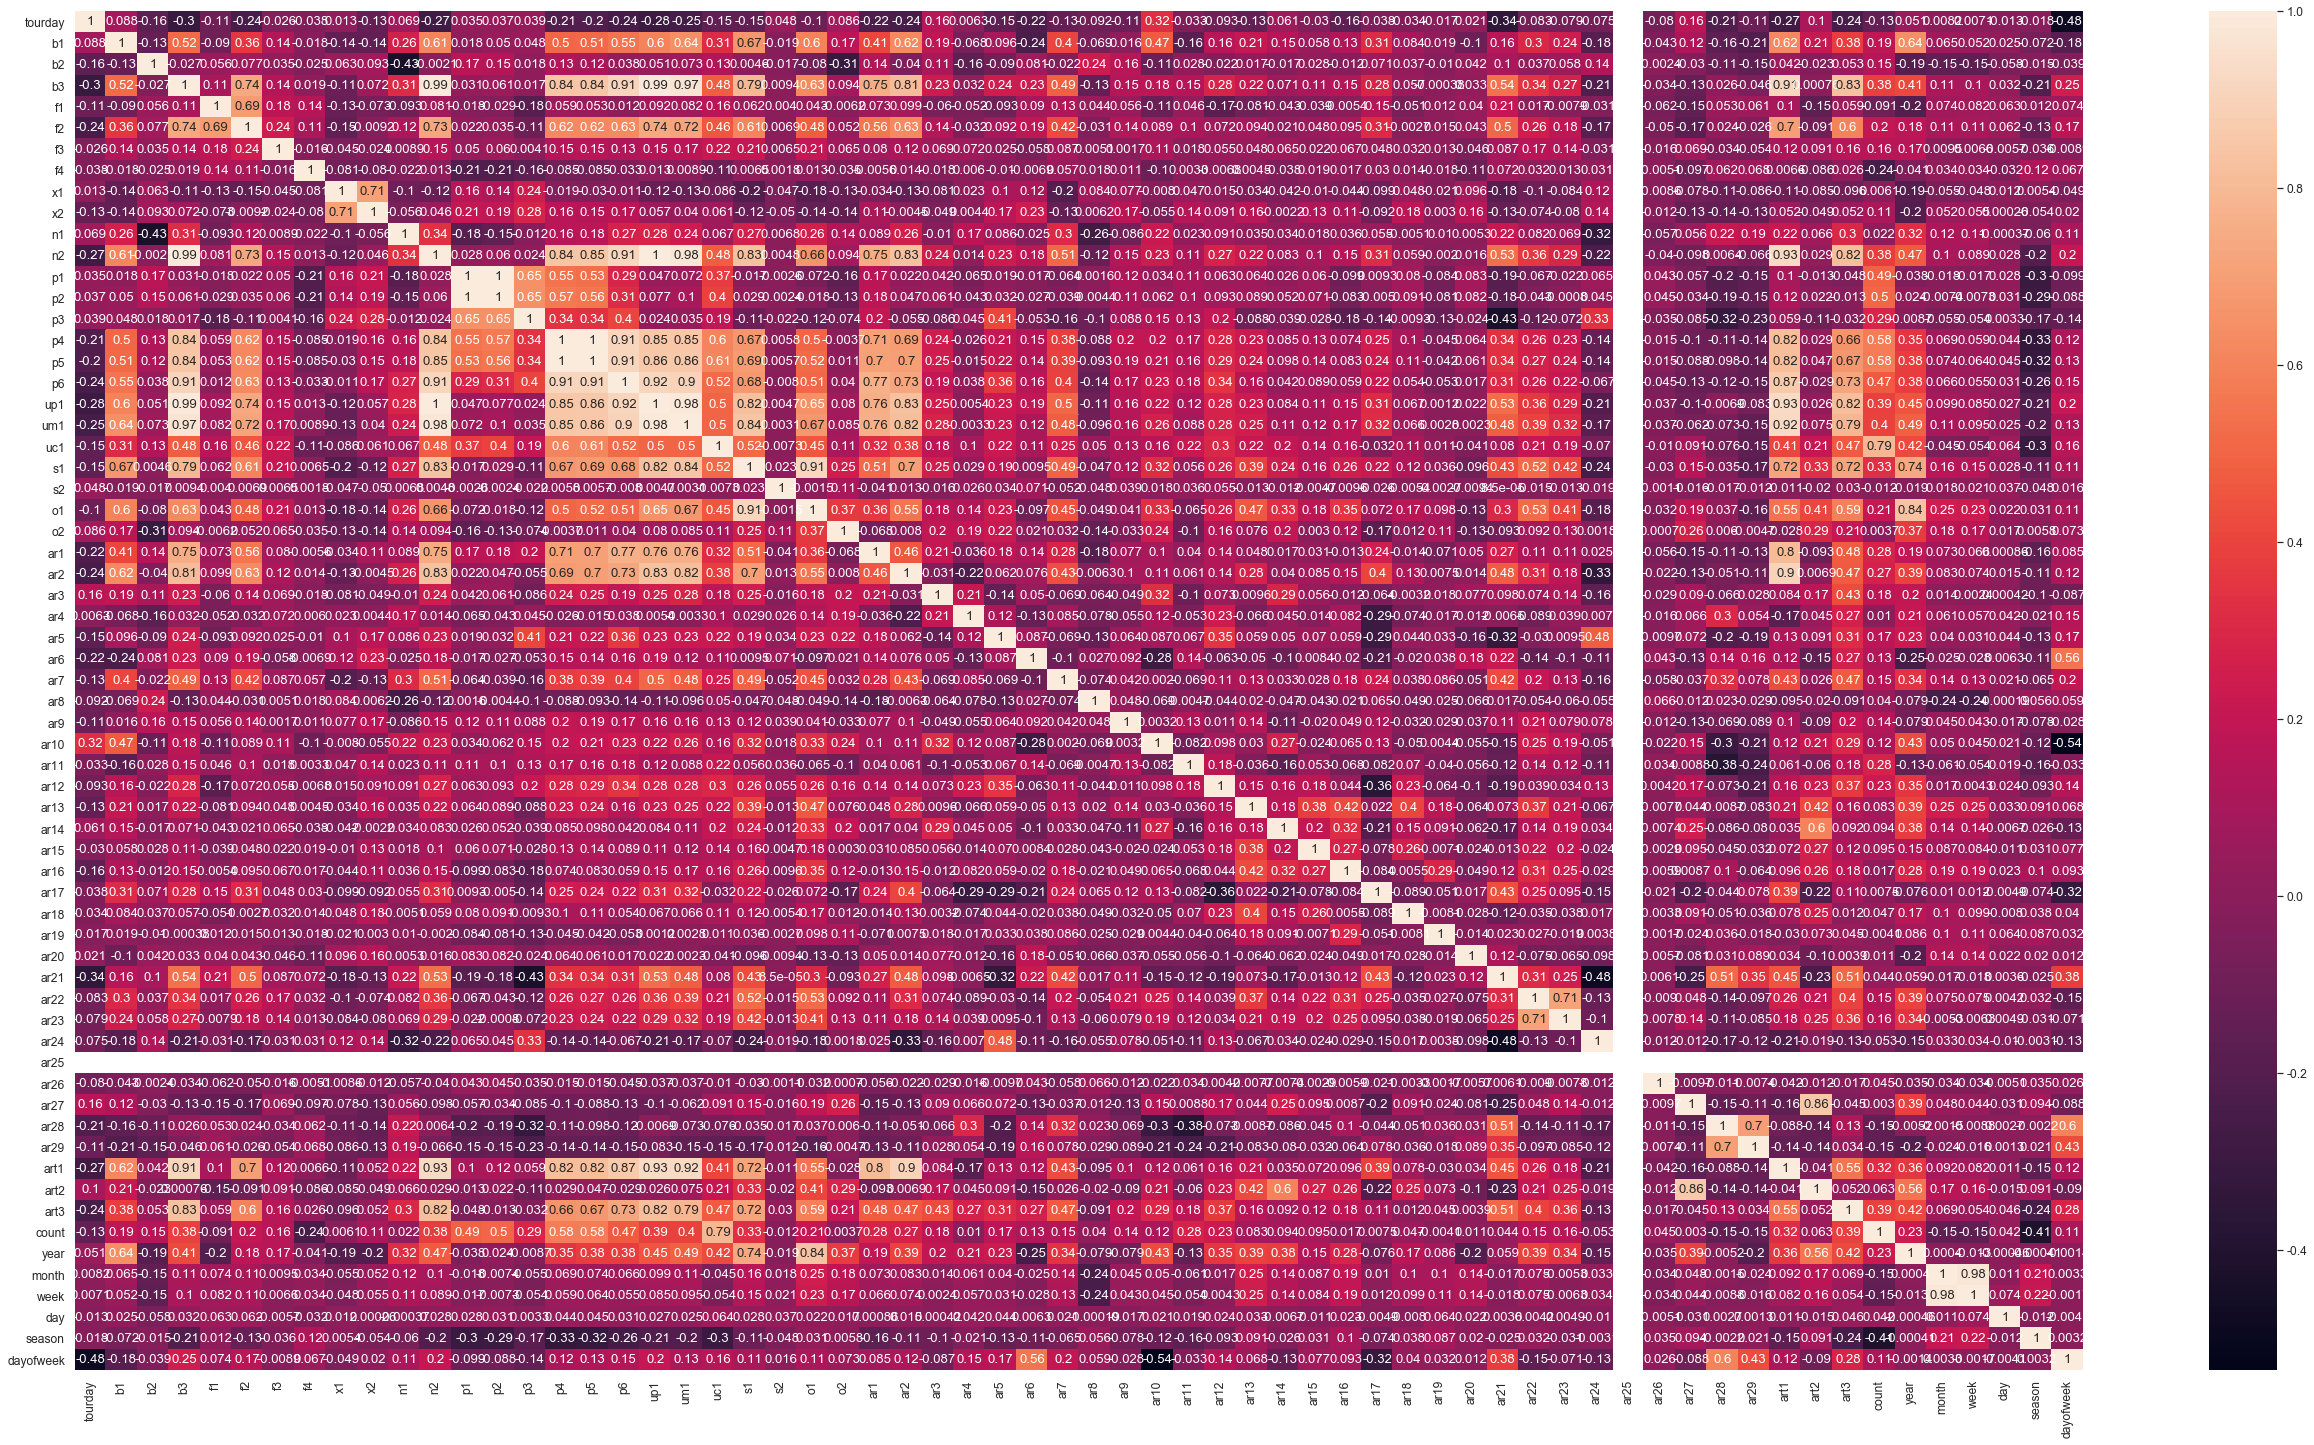

In [129]:
## 상관관계도를 시각화
transformed_corr_x = X_train.corr()
plt.figure(figsize=(45,25))
sns.heatmap(transformed_corr_x, annot=True)

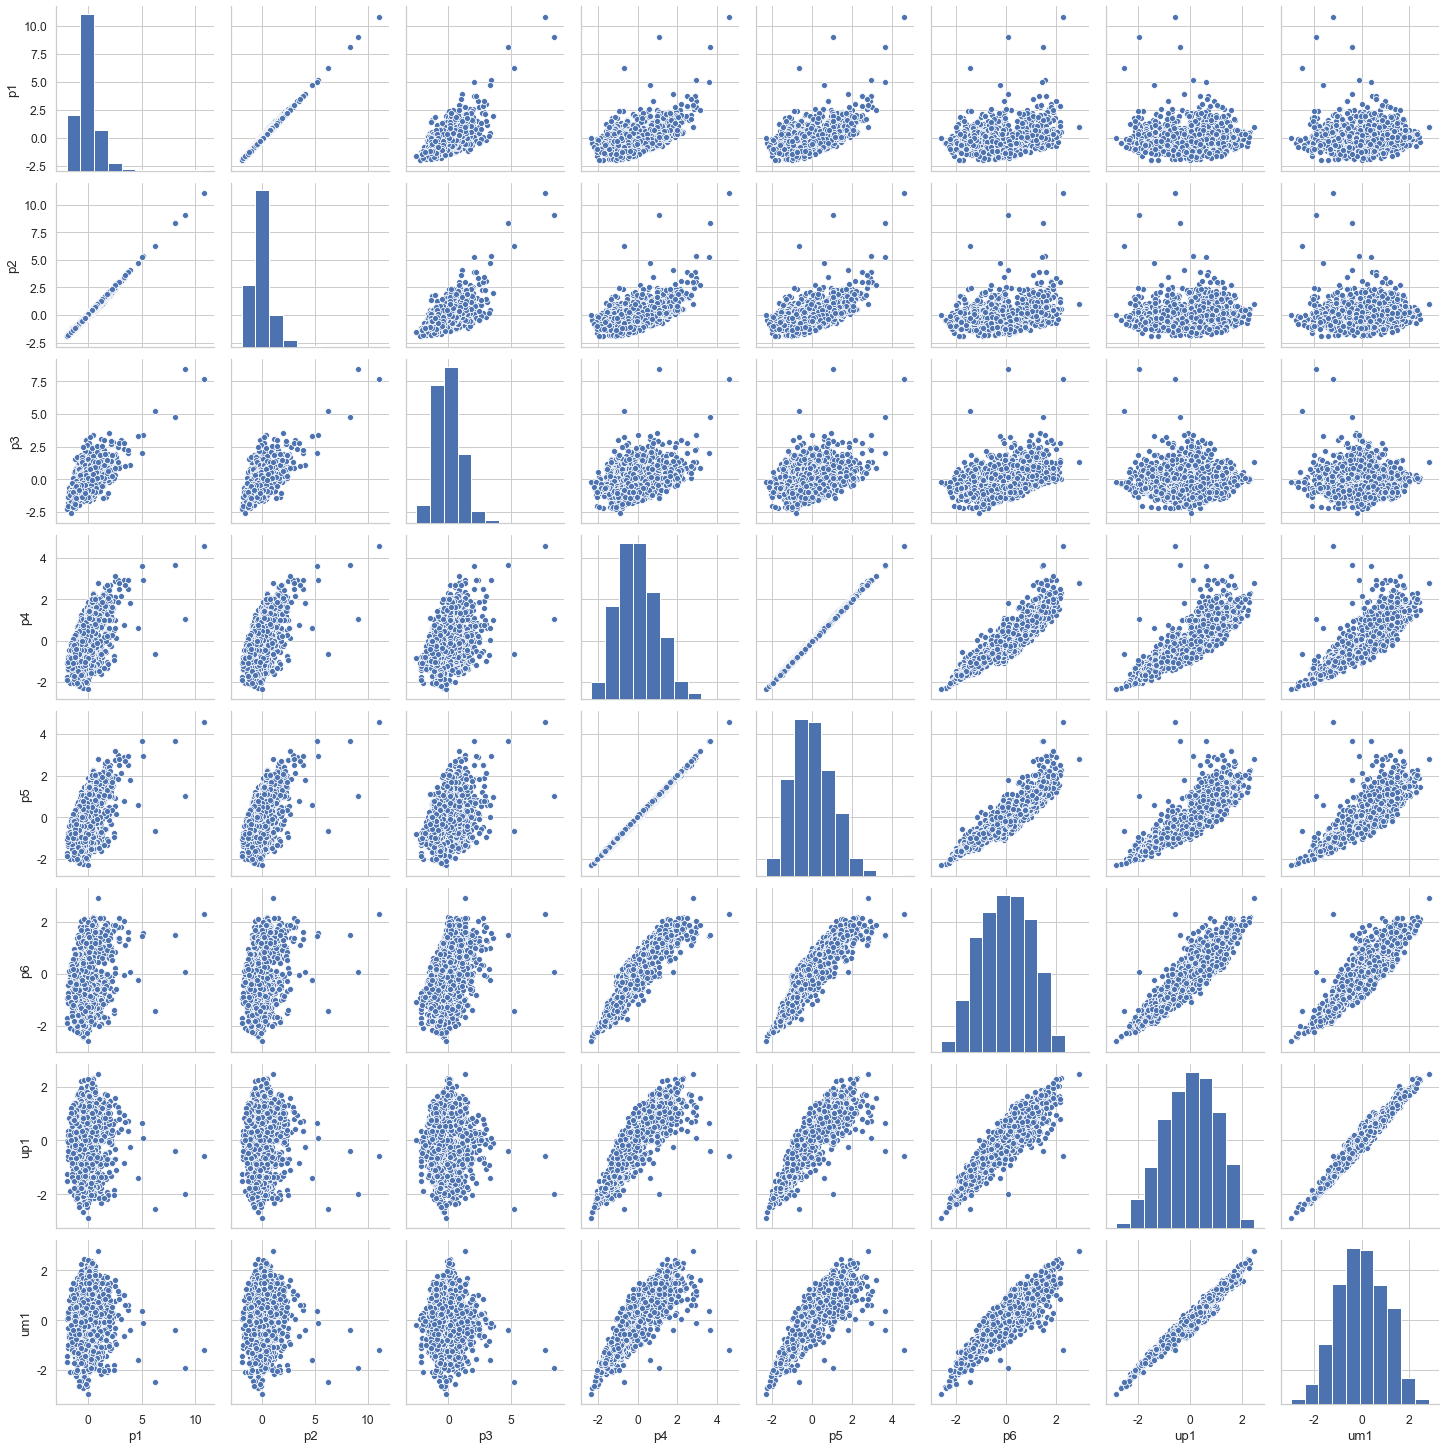

In [150]:
##범주형 데이터간의 관계도
sns.pairplot(X_train[['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'up1', 'um1']])

In [146]:
X_train.columns

Index(['datetime', 'tourday', 'b1', 'b2', 'b3', 'f1', 'f2', 'f3', 'f4', 'x1',
       'x2', 'n1', 'n2', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'up1', 'um1',
       'uc1', 's1', 's2', 'o1', 'o2', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6',
       'ar7', 'ar8', 'ar9', 'ar10', 'ar11', 'ar12', 'ar13', 'ar14', 'ar15',
       'ar16', 'ar17', 'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24',
       'ar25', 'ar26', 'ar27', 'ar28', 'ar29', 'art1', 'art2', 'art3', 'count',
       'year', 'month', 'week', 'day', 'season', 'dayofweek'],
      dtype='object')

##  시계열 분석 진행
- label과 시계열 변수들간의 관계 파악

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Year tour amount')]

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Month tour amount')]

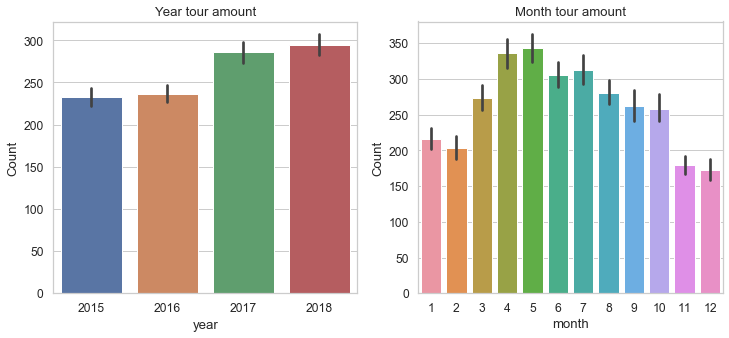

In [203]:
## 년도별, 월별 카운트수 시각화
figure, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(12,5)
sns.barplot(data=D_train, x="year", y="count", ax=ax1)
sns.barplot(data=D_train, x="month", y="count", ax=ax2)
ax1.set(ylabel='Count', title ="Year tour amount")
ax2.set(ylabel='Count', title ="Month tour amount")

### 위그래프 분석
- 2015년부터 2018년까지 꾸준히 증가하고 있는 추세를 보여주고 있음
- 주로 여행자들이 가장 집중되는 월로는 3~10월 사이가 가장 많은 것을 확인 할 수 있음
- 또한, 가장 많이 집중되는 월에서도 4, 5월달에 여행자가 가장 많은 것으로 나타남
- 2015년부터 2018년까지 전체 count를 통해 나온 패턴으로 여기서 다른 시각으로 각 년도별로 봣을때 어떠한 변화가 있을지 체크해볼 필요가 있음

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'season tour amount')]

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'dayofweek tour amount')]

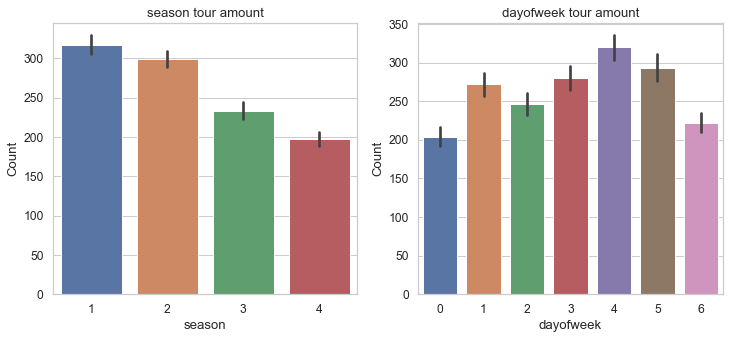

In [208]:
## 시즌별, 요일별 여행자 카운트수 시각화
figure, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(12,5)
sns.barplot(data=D_train, x="season", y="count", ax=ax1)
sns.barplot(data=D_train, x="dayofweek", y="count", ax=ax2)
ax1.set(ylabel='Count', title ="season tour amount")
ax2.set(ylabel='Count', title ="dayofweek tour amount")

### 위그래프 분석
- 1 : 봄 2: 여름 3: 가을 4 : 겨울
- 주로 봄, 여름에 여행을 가장 많이 가는 것을 확인 할 수 있음
- 0 : 월, 1: 화, 2: 수, 3: 목, 4: 금, 5: 토, 6: 일
- 목,금,토에 여행을 가장 많이가고 해외여행 특성상 1박2일 여행은 없고 최소 2박 3일 여행이기 때문에
  금요일에 여행을 출발하는 경우 많은 것으로 분석됨

In [170]:
## 트레인과 테스트 데이터를 복사하여 정규화 진행 예정
## 기존 원데이터를 사용하여 정규화 진행 후 진행 전 데이터를 비교하기 위해 데이터를 COPY하여 진행
D_train = train_outclear.copy()
D_test = test_outclear.copy()

In [171]:
D_train['year']= D_train["datetime"].dt.year
D_train['month']= D_train["datetime"].dt.month
D_train['week']= D_train["datetime"].dt.week
D_train['day']= D_train["datetime"].dt.day
D_train['dayofweek']= D_train["datetime"].dt.dayofweek

D_test["year"] = D_test["datetime"].dt.year
D_test["month"] = D_test["datetime"].dt.month
D_test['week']= D_test["datetime"].dt.week
D_test["day"] = D_test["datetime"].dt.day
D_test["dayofweek"] = D_test["datetime"].dt.dayofweek

In [172]:
D_train['dayofweek']

0       3
1       4
2       5
3       6
4       0
       ..
1456    3
1457    4
1458    5
1459    6
1460    0
Name: dayofweek, Length: 1461, dtype: int64

In [191]:
def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

D_train['season'] = X_train.month.apply(badToRight)

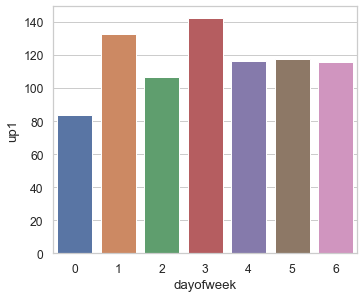

In [173]:
#계절과 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='dayofweek',y='up1',data=D_train.groupby('dayofweek')['up1'].mean().reset_index())

In [154]:
# 월별 데이터 모아보기
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)
X_train["year_month"] = X_train["datetime"].apply(concatenate_year_month)
print(X_train.shape)
X_train[["datetime", "year_month"]].head()

(1461, 66)


datetime year_month
0 2015-01-01     2015-1
1 2015-01-02     2015-1
2 2015-01-03     2015-1
3 2015-01-04     2015-1
4 2015-01-05     2015-1

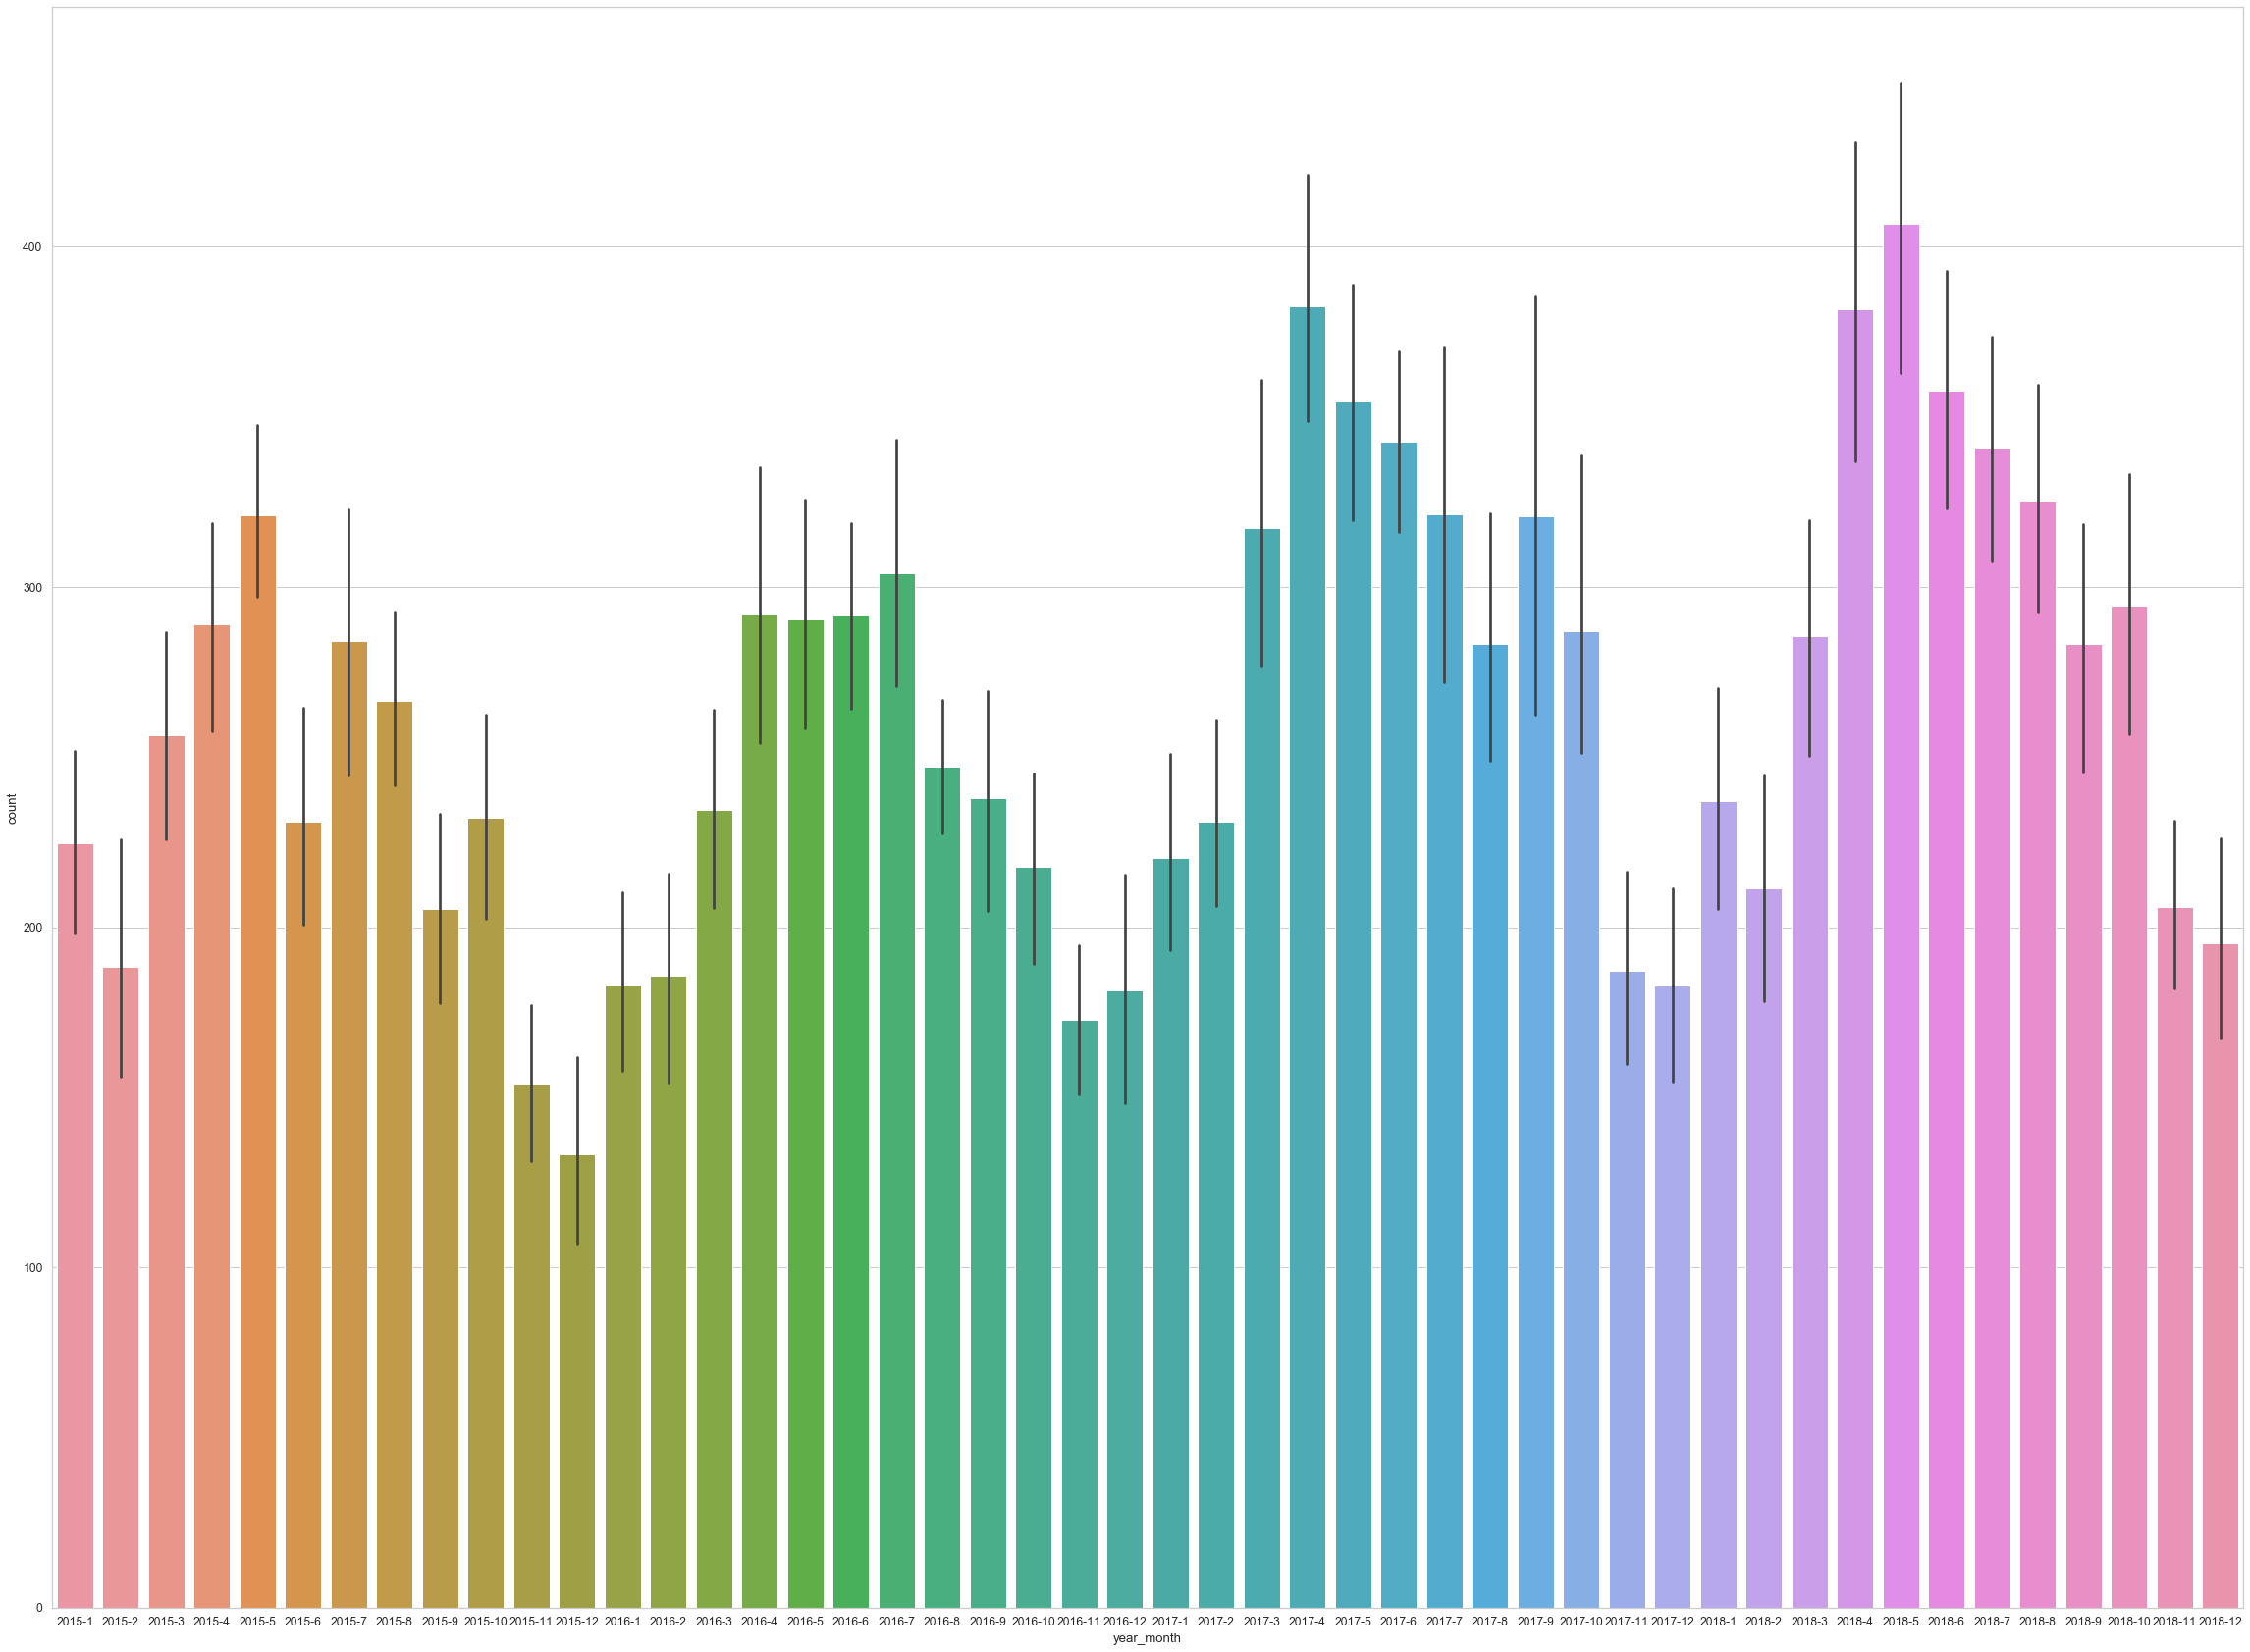

In [155]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(40,30)

sns.barplot(data=X_train, x="year_month",y="count",ax=ax1)

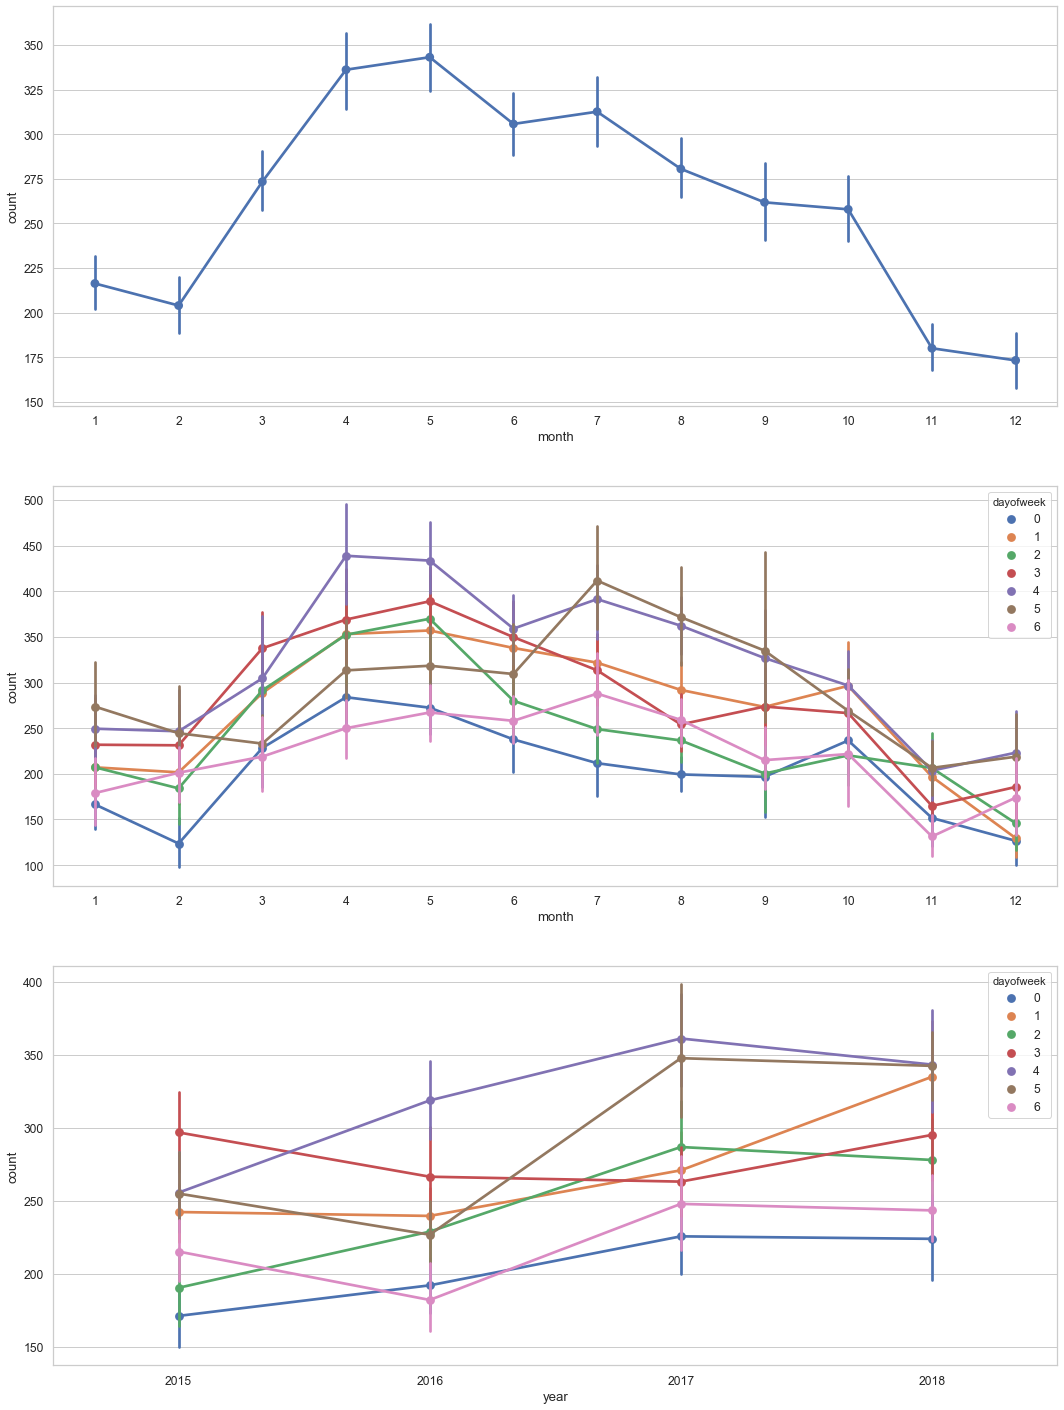

In [195]:
fig,(ax1,ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18,25)

sns.pointplot(data=D_train, x="month", y="count", ax=ax1)

sns.pointplot(data=D_train, x="month", y="count", hue="dayofweek", ax=ax2)

sns.pointplot(data=D_train, x="year", y="count", hue="dayofweek", ax=ax3)


In [190]:
D_train.head()

datetime  tourday  b1  b2   b3  f1   f2  f3  f4  x1  x2  n1    n2  \
0 2015-01-01        9   2  12  101   3  456  30   0   0   4  18  2145   
1 2015-01-02        9   3   2   81   3  304  27  -1   0  65  18  1625   
2 2015-01-03        8   1   4   81   3  285  14  -1   0  38  18  1600   
3 2015-01-04        9   2   3   82   4  349  23   0   0  36  19  1710   
4 2015-01-05       10   4   5   54   3  202  20   0   1  90  18  1173   

        p1       p2      p3         p4         p5        p6  up1  um1  uc1  \
0  2049069  2026017  429403  235643000  230966000  44658000  115  102   13   
1  2106767  2037388  442012  181182000  173178000  36245000   86   78   11   
2  1809174  1768764  389366  155589000  150345000  29202500   86   78    7   
3  1851356  1813406  412582  161068000  155953000  32594000   87   78   14   
4  2323650  2235580  490352  146390000  138606000  29911500   63   60    5   

    s1  s2  o1  o2  ar1  ar2  ar3  ar4  ar5  ar6  ar7  ar8  ar9  ar10  ar11  \
0  253   3  82   3   28   25   14    0    3    5    6    1    1     2     8   
1  194   3  62   4   26   18    9    0    6    2    8    1    0     2     6   
2  198   3  77   4   19   20    4    0    7    8    1    1    0     1    13   
3  165   3  57   3   16   21   10    0    3    6    8    1    0     0     4   
4  118   3  22   3   24   15    5    0    2    2    6    1    0     0     4   

   ar12  ar13  ar14  ar15  ar16  ar17  ar18  ar19  ar20  ar21  ar22  ar23  \
0     5     0     0     0     0     1     0     0     0    16     0     0   
1     5     0     0     0     0     1     0     0     0     0     0     0   
2     3     0     0     0     0     0     0     0     0     9     0     0   
3     2     0     0     0     0     2     0     0     0    13     0     0   
4     0     0     0     0     0     1     0     0     0     3     0     0   

   ar24  ar25  ar26  ar27  ar28  ar29  art1  art2  art3  count  year  month  \
0     0     0     0     0     0     0    53     0    62    321  2015      1   
1     2     0     0     0     0     0    44     0    42    271  2015      1   
2     0     0     0     0     0     0    39     0    47    315  2015      1   
3     0     0     0     0     1     0    37     0    50    271  2015      1   
4     0     0     0     0     0     0    39     0    24    109  2015      1   

   week  day  dayofweek  
0     1    1          3  
1     1    2          4  
2     1    3          5  
3     1    4          6  
4     2    5          0